![](https://dbuscombe-usgs.github.io/MLMONDAYS/img/favicon.ico)

# ML-Mondays. Week 1: Supervised Image Recognition


See the [course website](https://dbuscombe-usgs.github.io/MLMONDAYS/) for more information

>A) Live session (***this notebook***): we'll work through jupyter notebooks containing workflows for image recognition (whole image classification). We'll be trying to answer the question, How much of the Texas coastline is developed?. To answer this question, we will train a deep learning model to classify aerial (oblique) images of the Texas coast, categorized into several natural and non-natural landuse/cover classes. See the [data page](https://dbuscombe-usgs.github.io/MLMONDAYS/docs/doc2) for more information on the dataset.

>B) Optional class assignment: an additional dataset is provided that you can work on using the same models introduced in the class. The NWPU-RESISC45 is a publicly available benchmark for REmote Sensing Image Scene Classification (RESISC), created by Northwestern Polytechnical University (NWPU). We have curated a version of this dataset covering 11 scene classes. This dataset contains 7,700 images, with 700 images in each class. Participants will also be encouraged to adapt what they learned in the class to their own image recognition problems using their own data.

## Written by Daniel Buscombe

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

MIT License

Copyright (c) 2020, Marda Science LLC

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Introduction

In this lesson, we will train a neural network 'end to end' in an extremely discriminative approach that explicitly maps the classes to the image features, and optimized to extract the features that explicitly predict the class. The network works by linking an image feature extractor to a classifying head, such that feature extraction is limited to only those that help predict the class. The feature extraction therefore results in classification directly. 

For datasets where classes are obviously distinct, this is an extremely successful approach. We will see this with the NWPU dataset. However, for the TAMUCC dataset, where there is a lot more variability within classes and a lot less variability within classes, we will see how successful this approach is.


### Overview

1. Set up a data workflow to feed the model as it trains
  * use batches fed optimally to the GPU from TFRecord files
  * use data augmentation as a regularization strategy
  * split into train (40% of the data) and validation portions (60%)
2. Train it
  * use transfer learning to train a classifier
  * use a learning rate scheduler to pass variable learning rates to the model as it trains
  * use 'early stopping' to base cessation of training on observed plateauing of validation loss
  * use a checkpoint to monitor validation loss and save the best model weights when the validation loss improves
  * use class weightings to lessen effects of class imbalance
3. Evaluate it
  * study the model training history - the loss and accuracy curves of train and validation sets
  * evaluate the performance of the trained model on the validation set
  * plot a 'confusion matrix' of correspondences between actual and estimate class labels
  * read some sample images from file, and use the model for prediction 
4. Look at results from a  similar workflow on different class subsets

### Live discussion points
* How does this work?
* What are the biggest levers on training? (optimizer, learning rate, loss function, augmentation, dropout, model architecture, amount of data, etc)
* Why is accuracy better for NWPU data compared to TAMUCC data?
* How to apply to your data?
* When and how to use transfer learning?


### Mini-lecture 2: ML Mondays overview

> Slides are [here](https://docs.google.com/presentation/d/1lyZ0YAzP-9pLLTyAuwBgmD7uBO83MkJF1e-Ps3xXlgs/edit?usp=sharing)

In [1]:
import os

if os.getcwd() is not "/home/jovyan/MLMONDAYS/1_ImageRecog":
    os.chdir('/home/jovyan/MLMONDAYS/1_ImageRecog')
print(os.getcwd())

/home/jovyan/MLMONDAYS/1_ImageRecog


The following notebook is equivalent (in result) to running the following script inside this directory, which you could do by uncommenting and running the cell below

In [2]:
# !python tamucc_imrecog_part3c.py

You should have the data already if you followed part A, but in case you don't ...

In [3]:
# if not os.path.exists(os.getcwd()+'/data/tamucc/full_2class/400/tamucc00-199.tfrec'):
#     print('Downloading data ... takes a few minutes')
#     ! python download_data.py

Okay, first we'll define some more variables 


* `BATCH_SIZE` is the number of image--label pairs you will provide the model during each step of model training. You'll notice how I have made this a function of the image size - the reason is that I'm trying to limit the amount of memory this data will consume on my GPU. Generally speaking, larger batch sizes promote more stable model convergences (i.e. a relatively smooth decreasing loss curve). However, sometimes it is beneficial to have the model see small batches, especially if the model uses batch normalization

* `MAX_EPOCHS` is the maximum number of epochs to train models over. This will almost never be reached, because we'll use something called "early stopping" that will terminate model training if the validation loss isn't improving (i.e. lowering) after a certain amount of time

The following varibles relate to how we will specify the learning rate that the model will use at every model training epoch, known as "learning rate scheduling"

* `start_lr`. The starting learning rate. I usually specify these as round order of magnitudes e.g. 1e-5 instead of 0.00001
* `min_lr`. The minimum learning rate
* `max_lr`. The maximum learning rate 1e-3
* `rampup_epochs`. The number of epcohs to ramp up to the maximum
* `sustain_epochs`. The number of epochs to stay at the maximum
* `exp_decay`. The rate of exponential decay (larger numbers = faster rate of decay)

In [4]:
#start with a high validation split. If model poor on train data, can decrease
VALIDATION_SPLIT = 0.6

#start small - can increase later with larger hardware
TARGET_SIZE= 400

if TARGET_SIZE==400:
   BATCH_SIZE = 6
elif TARGET_SIZE==224:
   BATCH_SIZE = 16

MAX_EPOCHS = 100

ims_per_shard = 200

start_lr = 1e-5 #0.00001
min_lr = start_lr
max_lr = 1e-3
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .9

There are a lot of libraries and functions that get imported from `imports.py`. I recommend you look at the contents to see what libraries and functions get imported - there are utilities for file input/output, plotting, making models and more

Ensure you have `from tamucc_imports import *` uncommented and `from nwpu_imports import *` commented out before running the next cell

In [5]:
!head -n 33 imports.py

# Written by Dr Daniel Buscombe, Marda Science LLC
# for "ML Mondays", a course supported by the USGS Community for Data Integration
# and the USGS Coastal Change Hazards Program
#
# MIT License
#
# Copyright (c) 2020, Marda Science LLC
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PU

In [6]:
from imports import *

Version:  2.2.0
Eager mode:  True
GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [7]:
#! python download_data.py


### Train a model to classify 4 classes


We implement a custom deep neural network for classification, based on a MobileNetV2 feature extractor and a further set of layers for feature distillation and classification.

The feature extractor based on MobileNetV2 uses weights learned from classifying imagenet classes. It was then trained further on the 4-class TAMUCC subset, without class weights. We initiate the model with those weights. Then train for one last round, to ***fine-tune*** the model to the 4 classes, with class weights that will attempt to ameliorate the issues with unequal numbers of example images per class

We define lots of variables:

* patience: when training the model, we will use a strategy known as 'early stopping' to decide when to stop model training. It does this by monitoring improvement in the validation loss. If no improvement in validation loss is made over `patience` epochs, model training is terminated early
* data_path: where the tfrecord files you wish to use are
* json_file: a json format file that lists the classes (optionally, you could hard code them in as a list of strings)
* filepath: this is the model weights filepath. This is the .h5 file that contains the trained model weights, and is updated during training
* sample_data_path: this is where example jpeg images reside
* initial_weights: in this particular example, we are going to employ transfer learning, using weights inherited from a previous model training on the same dataset but with different hyperparameters




In [8]:
data_path= os.getcwd()+os.sep+"data/tamucc/full_4class/400"

json_file = os.getcwd()+os.sep+'data/tamucc/full_4class/tamucc_full_4classes.json'

filepath = os.getcwd()+os.sep+'results/tamucc_full_4class_mv2_best_weights_model3.h5'

sample_data_path= os.getcwd()+os.sep+"data/tamucc/full_4class/sample"

initial_weights = os.getcwd()+os.sep+'results/tamucc_subset_4class_mv2_best_weights_model2.h5'

patience = 30

These are utility functions that we need to create train, validation, and evaluation (test) data sets

In [9]:
#-----------------------------------
def get_training_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: training_filenames
    OUTPUTS: batched data set object
    """
    return get_batched_dataset(training_filenames)

def get_validation_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: validation_filenames
    OUTPUTS: batched data set object
    """
    return get_batched_dataset(validation_filenames)

def get_validation_eval_dataset():
    """
    This function will return a batched dataset for model training
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: validation_filenames
    OUTPUTS: batched data set object
    """
    return get_eval_dataset(validation_filenames)

#-----------------------------------
def get_aug_datasets():
    """
    This function will create train and validation sets based on a specific
    data augmentation pipeline consisting of random flipping, small rotations,
    translations and contrast adjustments
    INPUTS: None
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: validation_filenames, training_filenames
    OUTPUTS: two batched data set objects, one for training and one for validation
    """
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
      tf.keras.layers.experimental.preprocessing.RandomRotation(0.01),
      tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
      tf.keras.layers.experimental.preprocessing.RandomContrast(0.1)
    ])

    augmented_train_ds = get_training_dataset().map(
      lambda x, y: (data_augmentation(x, training=True), y))

    augmented_val_ds = get_validation_dataset().map(
      lambda x, y: (data_augmentation(x, training=True), y))
    return augmented_train_ds, augmented_val_ds

#-----------------------------------
def get_all_labels(nb_images, VALIDATION_SPLIT, BATCH_SIZE):
    """
    "get_all_labels"
    This function will obtain the classes of all samples in both train and
    validation sets. For computing class imbalance on the whole dataset
    INPUTS:
        * nb_images [int]: number of total images
    OPTIONAL INPUTS: None
    GLOBAL INPUTS: VALIDATION_SPLIT, BATCH_SIZE
    OUTPUTS:
        * l [list]: list of integers representing labels of each image
    """
    l = []
    num_batches = int(((1-VALIDATION_SPLIT) * nb_images) / BATCH_SIZE)
    train_ds = get_training_dataset()
    for _,lbls in train_ds.take(num_batches):
        l.append(lbls.numpy())

    val_ds = get_validation_dataset()
    num_batches = int(((VALIDATION_SPLIT) * nb_images) / BATCH_SIZE)
    for _,lbls in val_ds.take(num_batches):
        l.append(lbls.numpy())

    l = np.asarray(l).flatten()
    return l

We get a list of filenames, read the CLASSES from the provided json file

Then we compute the variables we need to pass to model training, including the number of training and validation steps, training and validation datasets to feed to the model while it trains

In [10]:
filenames = sorted(tf.io.gfile.glob(data_path+os.sep+'*.tfrec'))

CLASSES = read_classes_from_json(json_file)
print(CLASSES)

nb_images = ims_per_shard * len(filenames)
print(nb_images)

split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

validation_steps = int(nb_images // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(nb_images // len(filenames) * len(training_filenames)) // BATCH_SIZE

print(steps_per_epoch)
print(validation_steps)

train_ds = get_training_dataset()

val_ds = get_validation_dataset()

[b'finegrained_sand_beaches', b'gravel_shell_beaches', b'salt_brackish_water_marshes', b'sheltered_solid_manmade']
6400
433
633


Let's take a look at a batch, drawn from the dataset. You'll notice that the imagery is dark - that is because it has been standardized (each image has its mean value substracted, then it is normalized by the standard deviation of the original image). This makes the pixel values scale between -1 and 1. The matplotlib `imshow` command is only showing the positive values, hence the general darkness

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


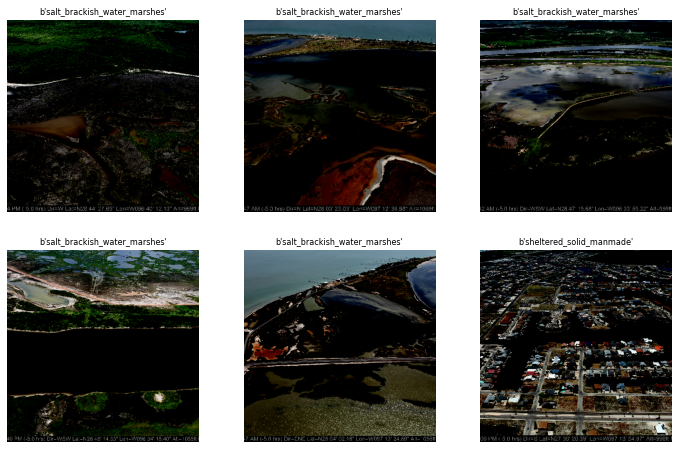

In [11]:
plt.figure(figsize=(12,12))
for imgs,lbls in train_ds.take(1):
  for count,im in enumerate(imgs):
     plt.subplot(int(BATCH_SIZE/2),int(BATCH_SIZE/2),count+1)
     plt.imshow(im)
     plt.title(CLASSES[lbls.numpy()[count]], fontsize=8)
     plt.axis('off')

We do the same for a batch of the validation data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


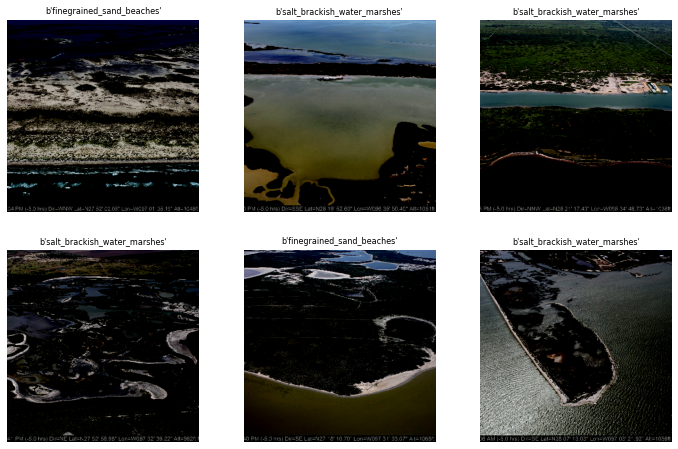

In [12]:
plt.figure(figsize=(12,12))
for imgs,lbls in val_ds.take(1):
  for count,im in enumerate(imgs):
     plt.subplot(int(BATCH_SIZE/2),int(BATCH_SIZE/2),count+1)
     plt.imshow(im)
     plt.title(CLASSES[lbls.numpy()[count]], fontsize=8)
     plt.axis('off')

Data augmentation is typically used to train modern deep neural networks. The primary purpose is ***regularization***

We use the `Dataset.map` functionality to create a dataset that yields batches of augmented images. In this case, data augmentation will happen asynchronously on the CPU. 


Next we apply our augmentation procedure to each dataset, and show examples from the augmented training set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


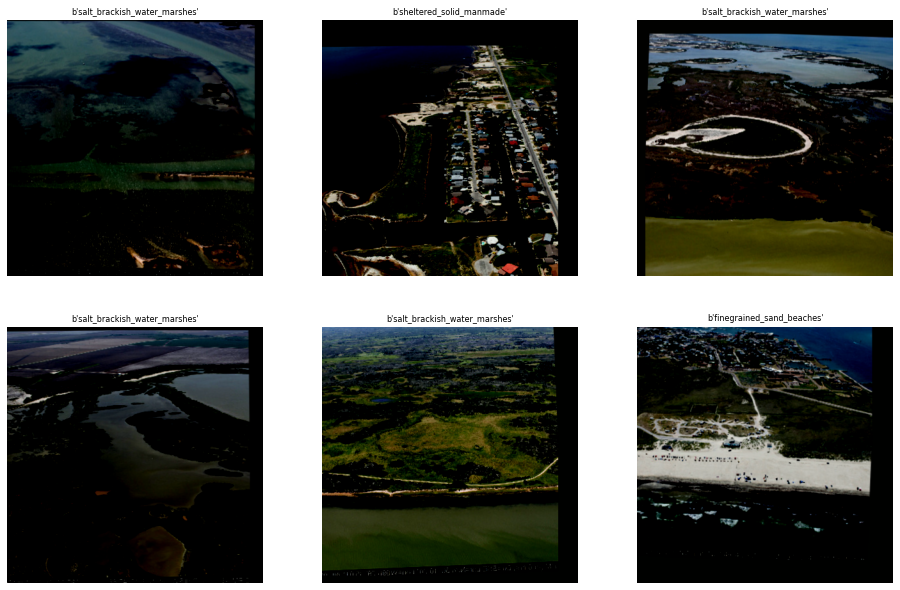

In [13]:
augmented_train_ds, augmented_val_ds = get_aug_datasets()

plt.figure(figsize=(16,16))
for im,l in augmented_train_ds.take(1):
    for count,im in enumerate(im):
       plt.subplot(int(BATCH_SIZE/2),int(BATCH_SIZE/2),count+1)
       plt.imshow(im)
       plt.title(CLASSES[l[count]], fontsize=8)
       plt.axis('off')

This function reads all labels from both test and validation datasets

then makes a quick histogram of the relative frequency of classes

In [14]:
l = get_all_labels(nb_images, VALIDATION_SPLIT, BATCH_SIZE)

Text(0, 0.5, 'Number of images')

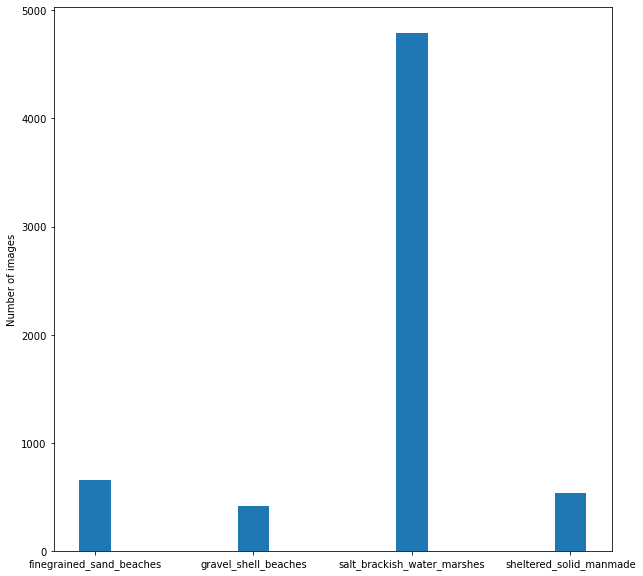

In [15]:
plt.figure(figsize=(10,10))
plt.hist(l, bins=np.arange(len(CLASSES)+1), rwidth=.2)
plt.gca().set_xticks([.5,1.5,2.5,3.5])
plt.gca().set_xticklabels([c.decode() for c in CLASSES])
plt.ylabel('Number of images')

It shows class imbalance - we will try to counter the effects of this during model traiing by computing per-class weights

Scikit-learn provide a handy utility for this occasion, called `class_weight`

Per-class weights will be given by number of images divided by the product of the number of classes and the frequency of the class. SO, they will vary inversely with the frequency of the class in the entire dataset. The loss function will be weighted less for these classes, reducing the tendency of the model to estimate the most frequenct class. 



In [16]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(l),
                                                 l)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 2.426403641881639, 1: 3.8810679611650487, 2: 0.33395989974937346, 3: 2.977653631284916}


/srv/conda/envs/pangeo/lib/python3.6/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3], y=[3 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


### How to choose a model

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/practices-model.png)


### How to set things up

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/practices.png)


Next we create a model instance, compile it, and define callbacks.

The model is called `transfer_learning_mobilenet_model` because it is based on a generic deep learning feature extractor (MobileNetV2), initialized using weights from the same model trained to classify imagenet imagery and classes. This transfer of weights from one model to another is an example of transfer learning.

In fact in this case the model was already trained on this dataset, so we load the weights from the previous model training. 

We define an `EarlyStopping` object to pass to the model `.fit()` function as a callback function. It monitors validation loss, and stops training if the loss hasn't improved for `patience` epochs (defined above)

Next we make a `ModelCheckpoint` to save model weights to `filepath` when validaton loss improves. This therefore keeps track and saves the "best only" weights

The final callback is the `LearningRateScheduler` that dictates to the model what learning rate to use, depending on epoch number. It calls a custom learning rate scheduler function, `lrfn` (defined in `imports.py`)

In [17]:
model = transfer_learning_mobilenet_model(len(CLASSES), (TARGET_SIZE, TARGET_SIZE, 3), dropout_rate=0.5)

model.compile(optimizer=tf.keras.optimizers.Adam(), 
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])


## transfer learning
model.load_weights(initial_weights)

earlystop = EarlyStopping(monitor="val_loss",
                              mode="min", patience=patience)

# set checkpoint file
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss',
                                verbose=0, save_best_only=True, mode='min',
                                save_weights_only = True)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

callbacks = [model_checkpoint, earlystop, lr_callback]


Visualize the model

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 401, 401, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 200, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 200, 200, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

You need these dependencies but they dont install on pangeo

In [19]:
# !conda install pydot graphviz -y

In [20]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


If `do_train` is `True`, the model will train

In [21]:
do_train=False

In [22]:
if do_train:

  history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, epochs=MAX_EPOCHS,
                        validation_data=val_ds, validation_steps=validation_steps,
                        callbacks=callbacks, class_weight = class_weights)

  K.clear_session()

If not training, just load the previously trained model weights straight into the model (the beauty of keras!)

In [23]:
if not do_train:
  model.load_weights(filepath)

> How to train models?

Access the slides [here](https://docs.google.com/presentation/d/1p7lDv3RoRzaW3U6n0KsOOui0zsEb9c8gzZGfgn-9_98/edit?usp=sharing)

## Model evaluation

When the model is trained, we will evaluate it in a variety of ways using unseen test data

First let's take a look at the model training history, to see how fast and variabily in convergenced to a solution

The plot on the left shows the training and validation accuracy over training epoch, and the right plot shows the correspodning loss curves

In [24]:
if do_train:
  n = len(history.history['accuracy'])

  plt.figure(figsize=(20,10))
  plt.subplot(121)
  plt.plot(np.arange(1,n+1), history.history['accuracy'], 'b', label='train accuracy')
  plt.plot(np.arange(1,n+1), history.history['val_accuracy'], 'k', label='validation accuracy')
  plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Accuracy', fontsize=10)
  plt.legend(fontsize=10)

  plt.subplot(122)
  plt.plot(np.arange(1,n+1), history.history['loss'], 'b', label='train loss')
  plt.plot(np.arange(1,n+1), history.history['val_loss'], 'k', label='validation loss')
  plt.xlabel('Epoch number', fontsize=10); plt.ylabel('Loss', fontsize=10)
  plt.legend(fontsize=10)


![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/evaluate.png)

Use the handy `.evaluate()` function of the model object to compute the average accuracy over the entire validation dataset, and display the mean accuracy in percent

(note that Dropout are inactive at inference time, so that layer won't affect our model results)

In [25]:
loss, accuracy = model.evaluate(get_validation_eval_dataset(), batch_size=BATCH_SIZE)
print('Test Mean Accuracy: ', round((accuracy)*100, 2),' %')

623/623 [==============================] - 30s 48ms/step - loss: 0.2476 - accuracy: 0.9230
Test Mean Accuracy:  92.3  %


![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/predict.png)

Get a list of filenames to test the model on, from the provided `sample_data_path`, and make a plot of each image. The title of each subplot is the actual class name, and the coloured box is the model's estimate. Green boxes indicate "correct" model estimate, and red boxes indicates "incorrect" model estimate

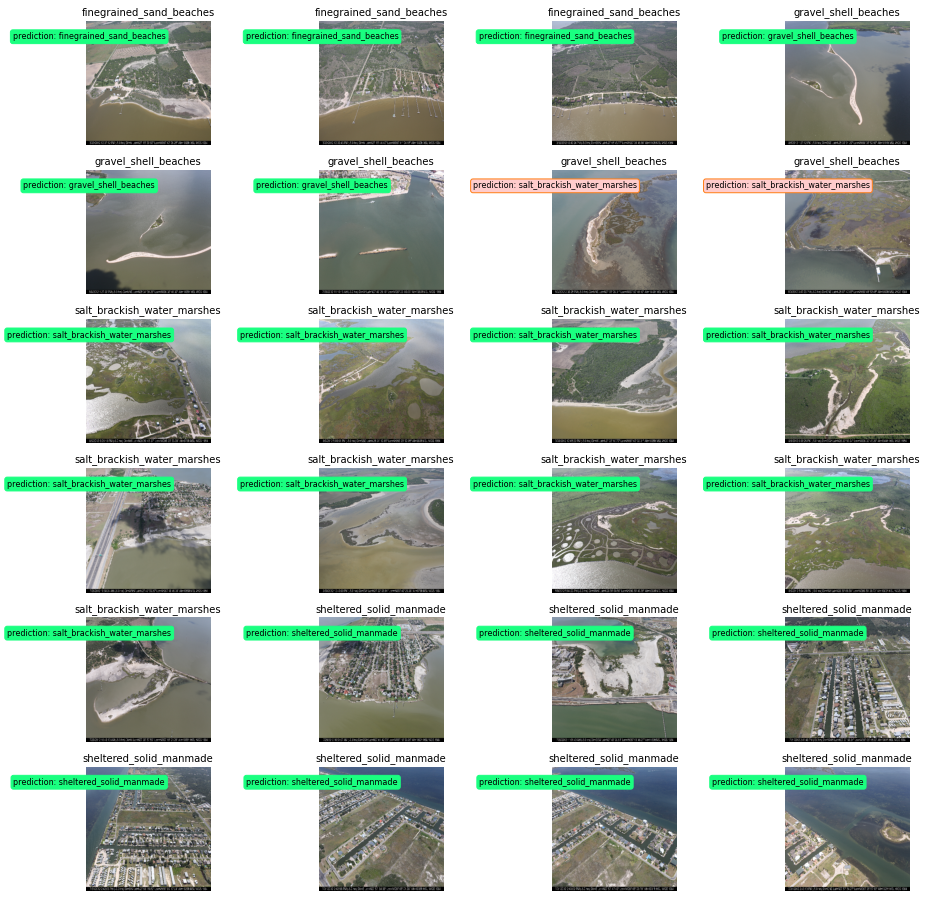

In [26]:
sample_filenames = sorted(tf.io.gfile.glob(sample_data_path+os.sep+'*.jpg'))

plt.figure(figsize=(16,16))

for counter,f in enumerate(sample_filenames):
    image, im = file2tensor(f, 'mobilenet')
    plt.subplot(6,4,counter+1)
    name = sample_filenames[counter].split(os.sep)[-1].split('_IMG')[0]
    plt.title(name, fontsize=10)
    plt.imshow(tf.cast(image, tf.uint8))
    plt.axis('off')

    scores = model.predict(tf.expand_dims(im, 0) , batch_size=1)
    n = np.argmax(scores[0])
    est_name = CLASSES[n].decode()
    if name==est_name:
       plt.text(10,50,'prediction: %s' % est_name,
                color='k', fontsize=8,
                ha="center", va="center",
                bbox=dict(boxstyle="round",
                       ec=(.1, 1., .5),
                       fc=(.1, 1., .5),
                       ))
    else:
       plt.text(10,50,'prediction: %s' % est_name,
                color='k', fontsize=8,
                ha="center", va="center",
                bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.1),
                       fc=(1., 0.8, 0.8),
                       ))

Finally, we are going to compute and show the confusion matrix

We analyze the entire validation set using `get_label_pairs`, which collates all true labels and uses the model to estimate labels

In [27]:
val_ds = get_validation_eval_dataset()

labs, preds = get_label_pairs(val_ds, model)

We use the scikit-learn utility `confusion_matrix` to compute the confusion matrix from the true labels `labs` and the model estimates `preds`. The values are normalized by row sums, values less than `thres` are zeroed out, and the matrix is plotted as a heatmap

([<matplotlib.axis.YTick at 0x7f9c2c17eda0>,
 [Text(0, 0.5, 'finegrained_sand_beaches'),
  Text(0, 1.5, 'gravel_shell_beaches'),
  Text(0, 2.5, 'salt_brackish_water_marshes'),
  Text(0, 3.5, 'sheltered_solid_manmade')])

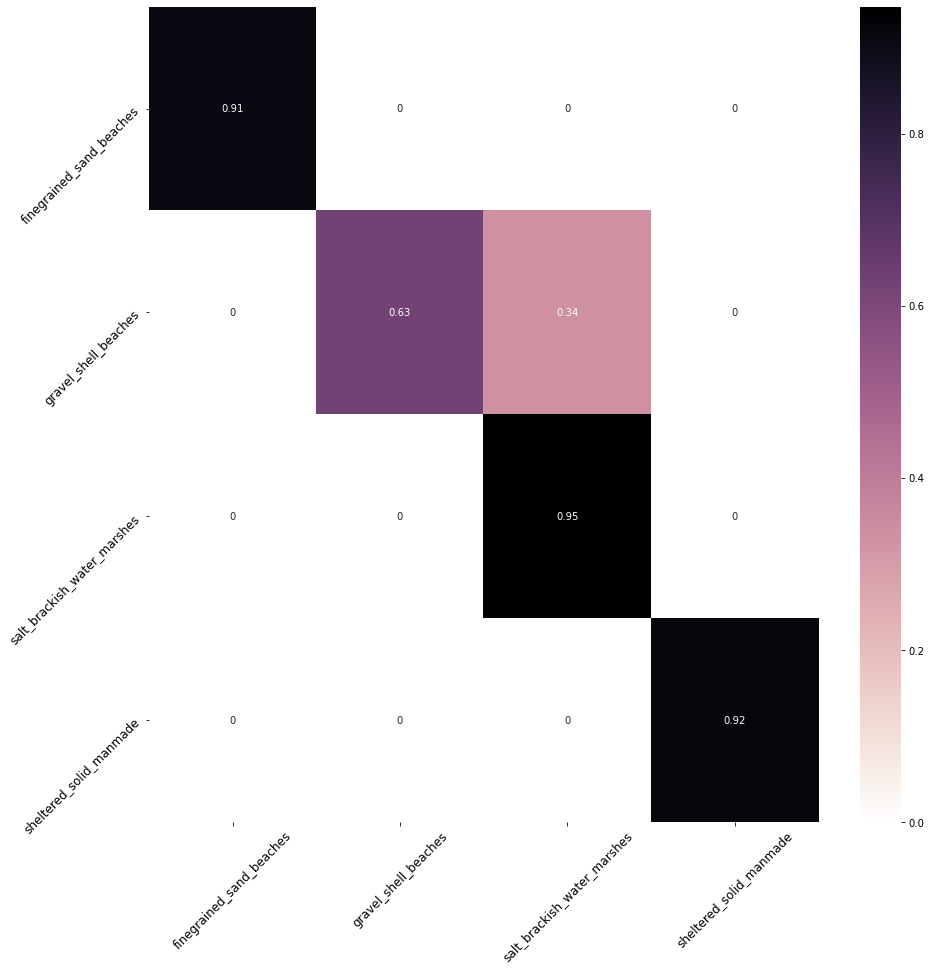

In [28]:
thres = 0.1
cm = confusion_matrix(labs, preds)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

cm[cm<thres] = 0

plt.figure(figsize=(15,15))
sns.heatmap(cm,
    annot=True,
    cmap = sns.cubehelix_palette(dark=0, light=1, as_cmap=True))

tick_marks = np.arange(len(CLASSES))+.5
plt.xticks(tick_marks, [c.decode() for c in CLASSES], rotation=45,fontsize=12)
plt.yticks(tick_marks, [c.decode() for c in CLASSES],rotation=45, fontsize=12)

# plt.show()

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/error.png)

### Discussion points

* How does this work?
* What are the biggest levers on training? (optimizer, learning rate, loss function, augmentation, dropout, model architecture, amount of data, etc)
* Why is accuracy better for NWPU data compared to TAMUCC data?
* How to apply to your data?
* When and how to use transfer learning?


### Recommendations

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/overkill.png)

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/overeffort.png)

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/overfitting.png)

![](https://raw.githubusercontent.com/dbuscombe-usgs/MLMONDAYS/master/1_ImageRecog/notebooks/assets/avoid_overfitting.png)

## Full TAMUCC Case study

There are several versions of the data. There are 2- and 3-class versions as well as the 4-class version we have just seen. These workflows highlight different strategies for model building including:

* transfer learning
* fine-tuning
* class-weighting
* custom versus 'stock' models

### 2-class ('developed', 'undeveloped')

#### Script 1. tamucc_imrecog_part1a.py

Implements a custom deep neural network for classification, on the data subset


In [29]:
from IPython.display import Image

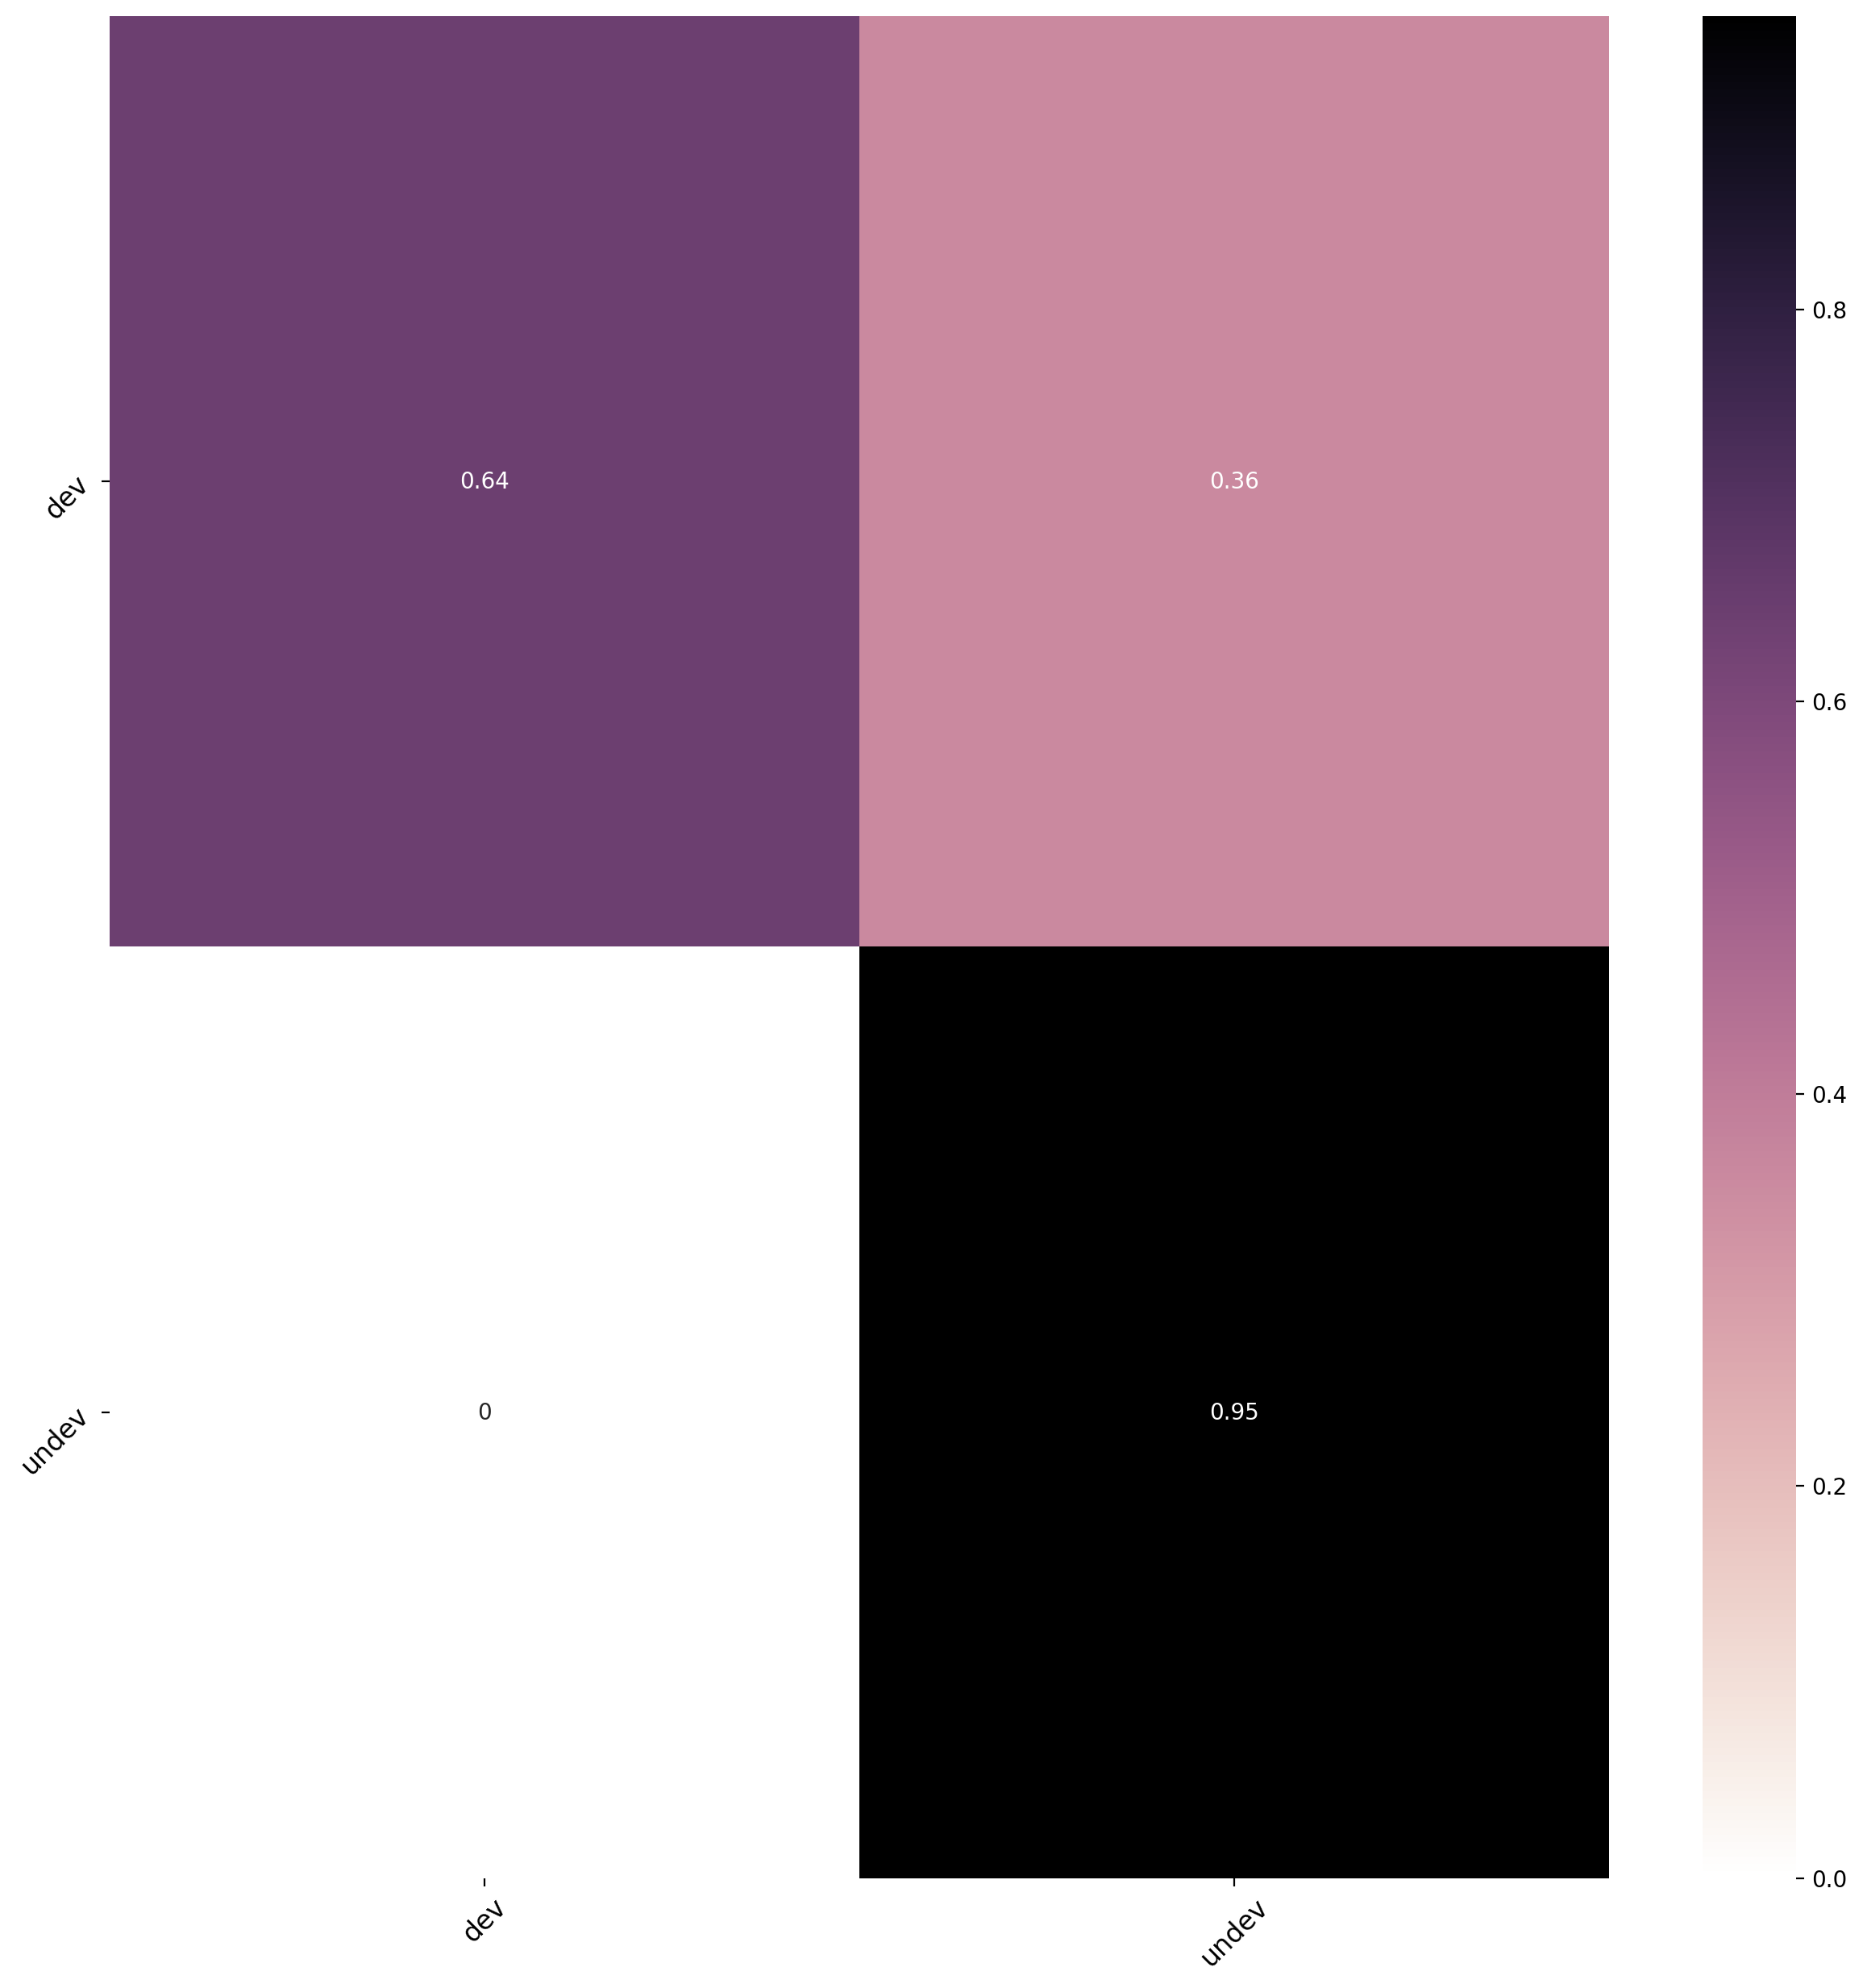

In [30]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_2class_mv2_model1_cm_val.png", width=500, height=500)


#### Script 2. tamucc_imrecog_part1b.py

Implements a custom deep neural network for classification, trained using class weights (a measure of the relative proportion of each class in the dataset), on the data subset


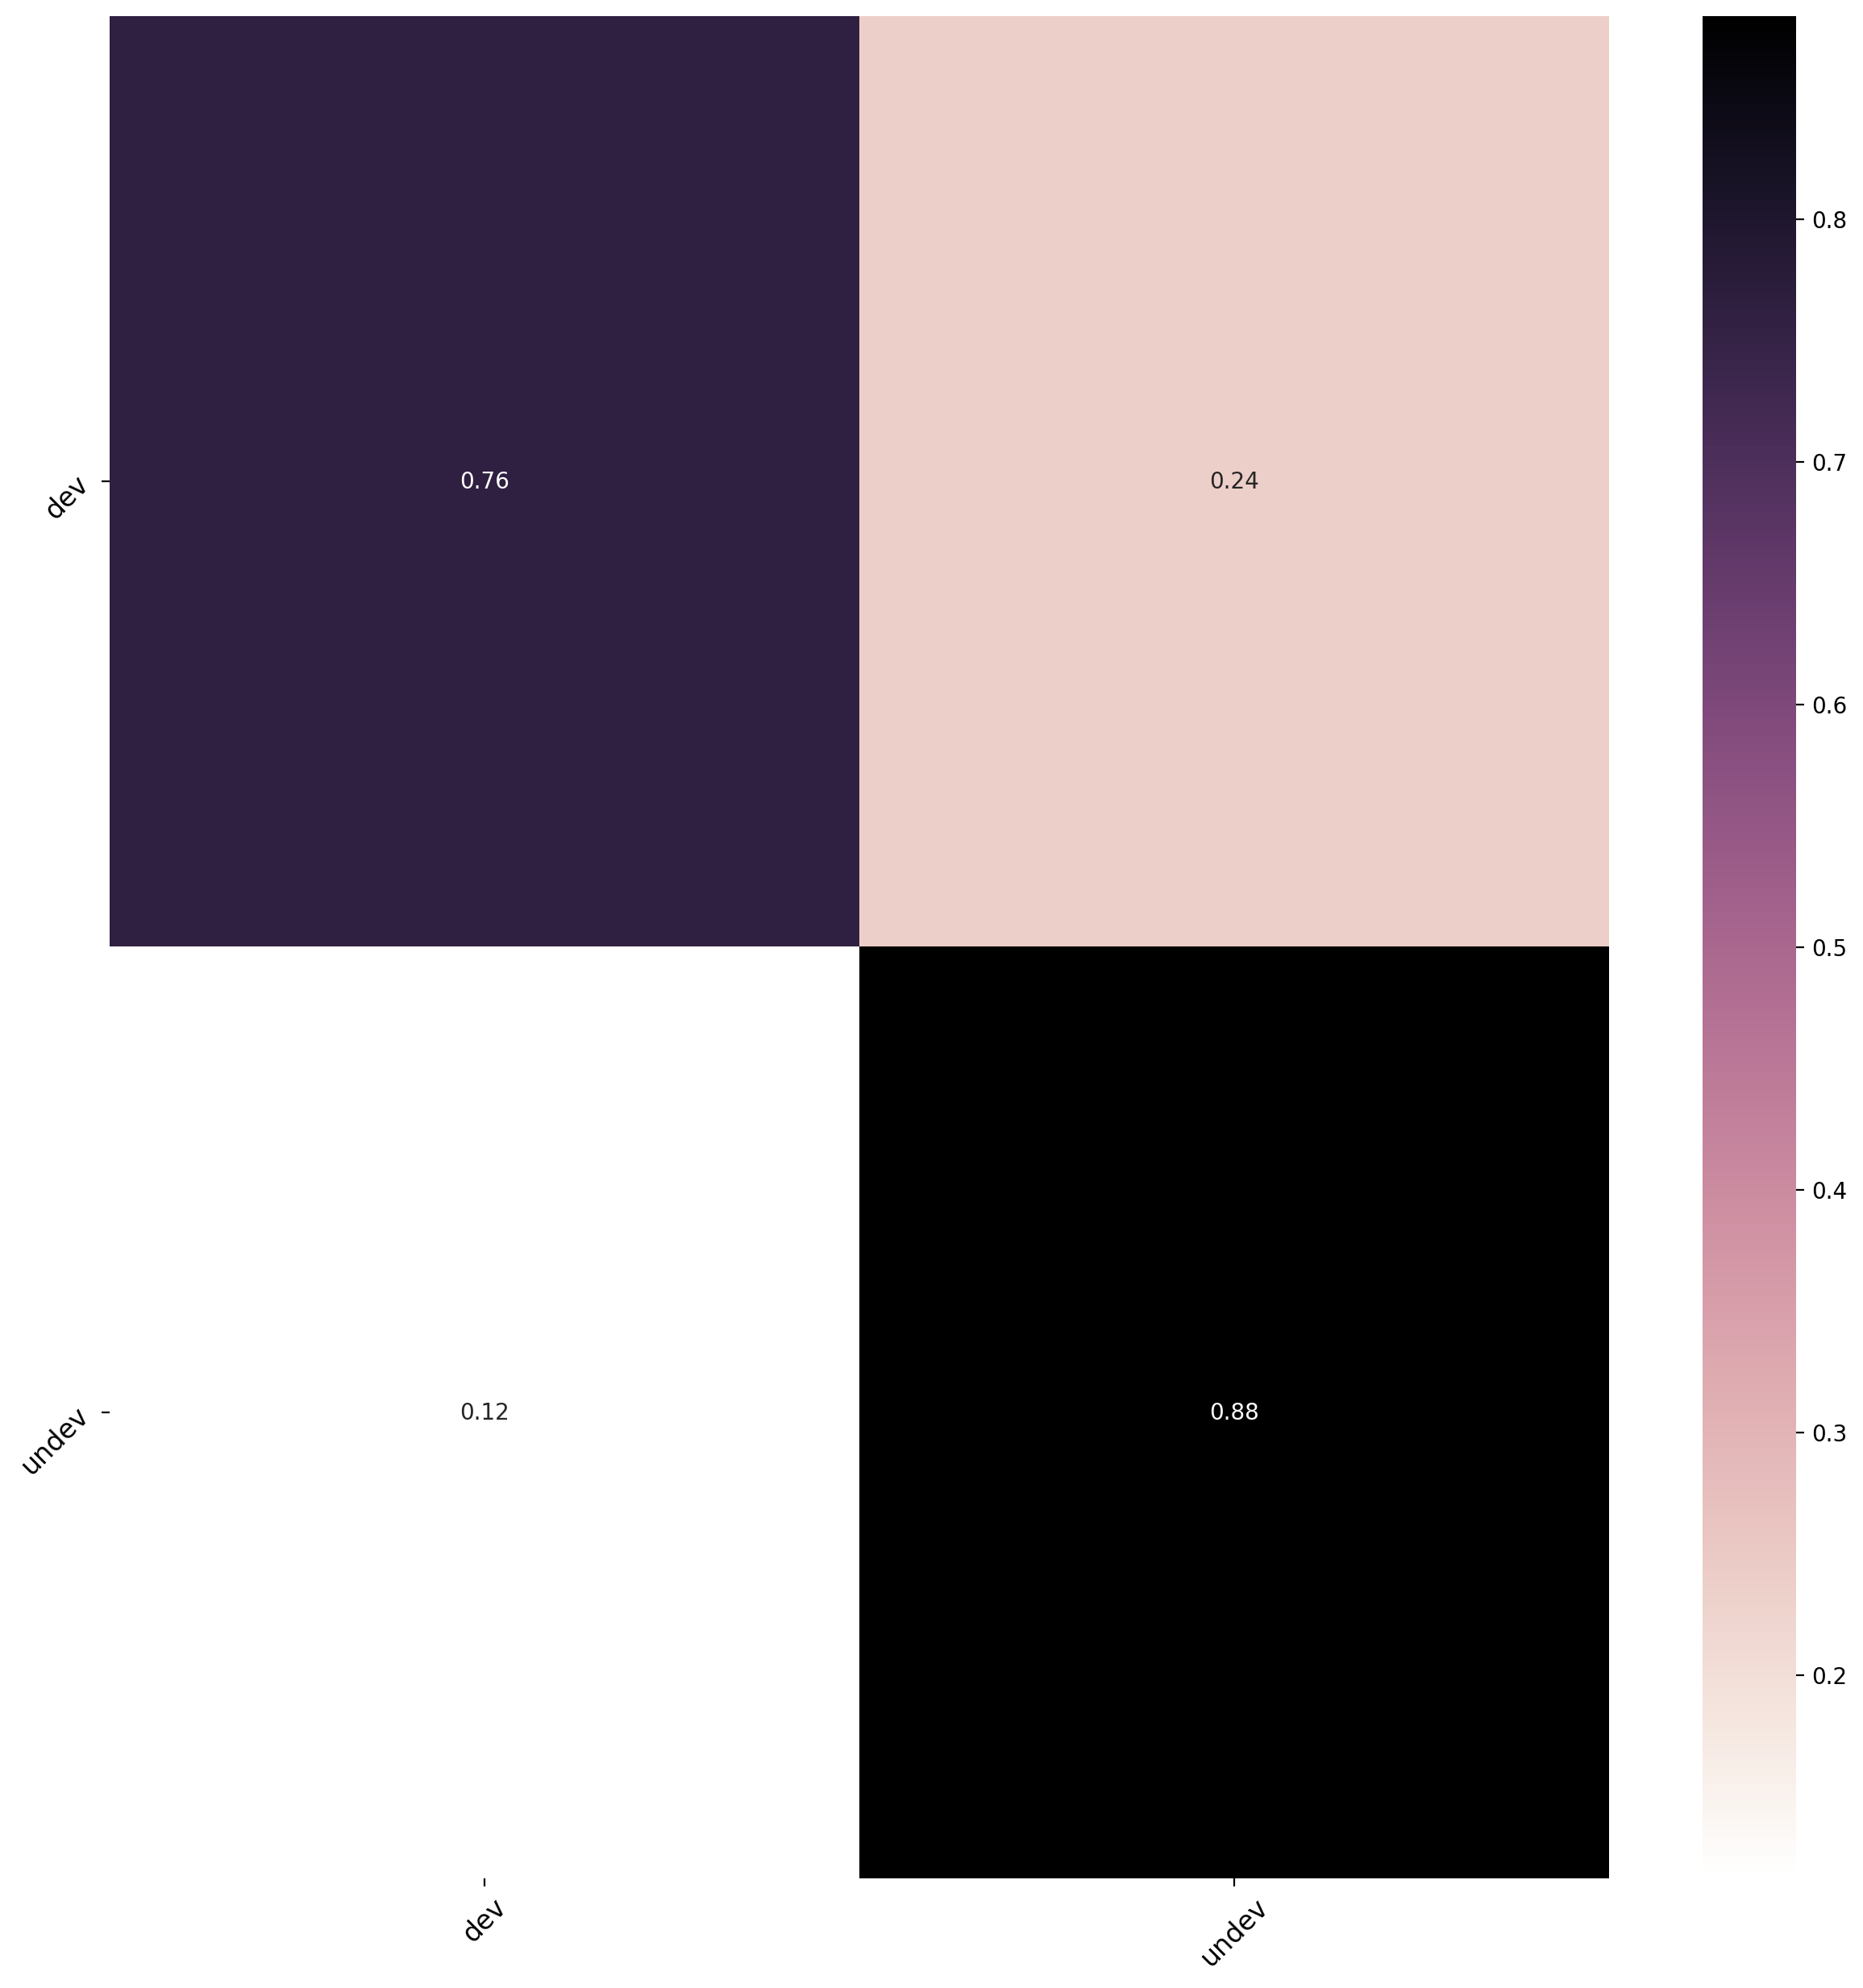

In [31]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_2class_mv2_model2_cm_val.png", width=500, height=500)


#### Script 3. tamucc_imrecog_part1c.py

Implements a custom deep neural network for classification, trained using class weights (a measure of the relative proportion of each class in the dataset), on the full dataset

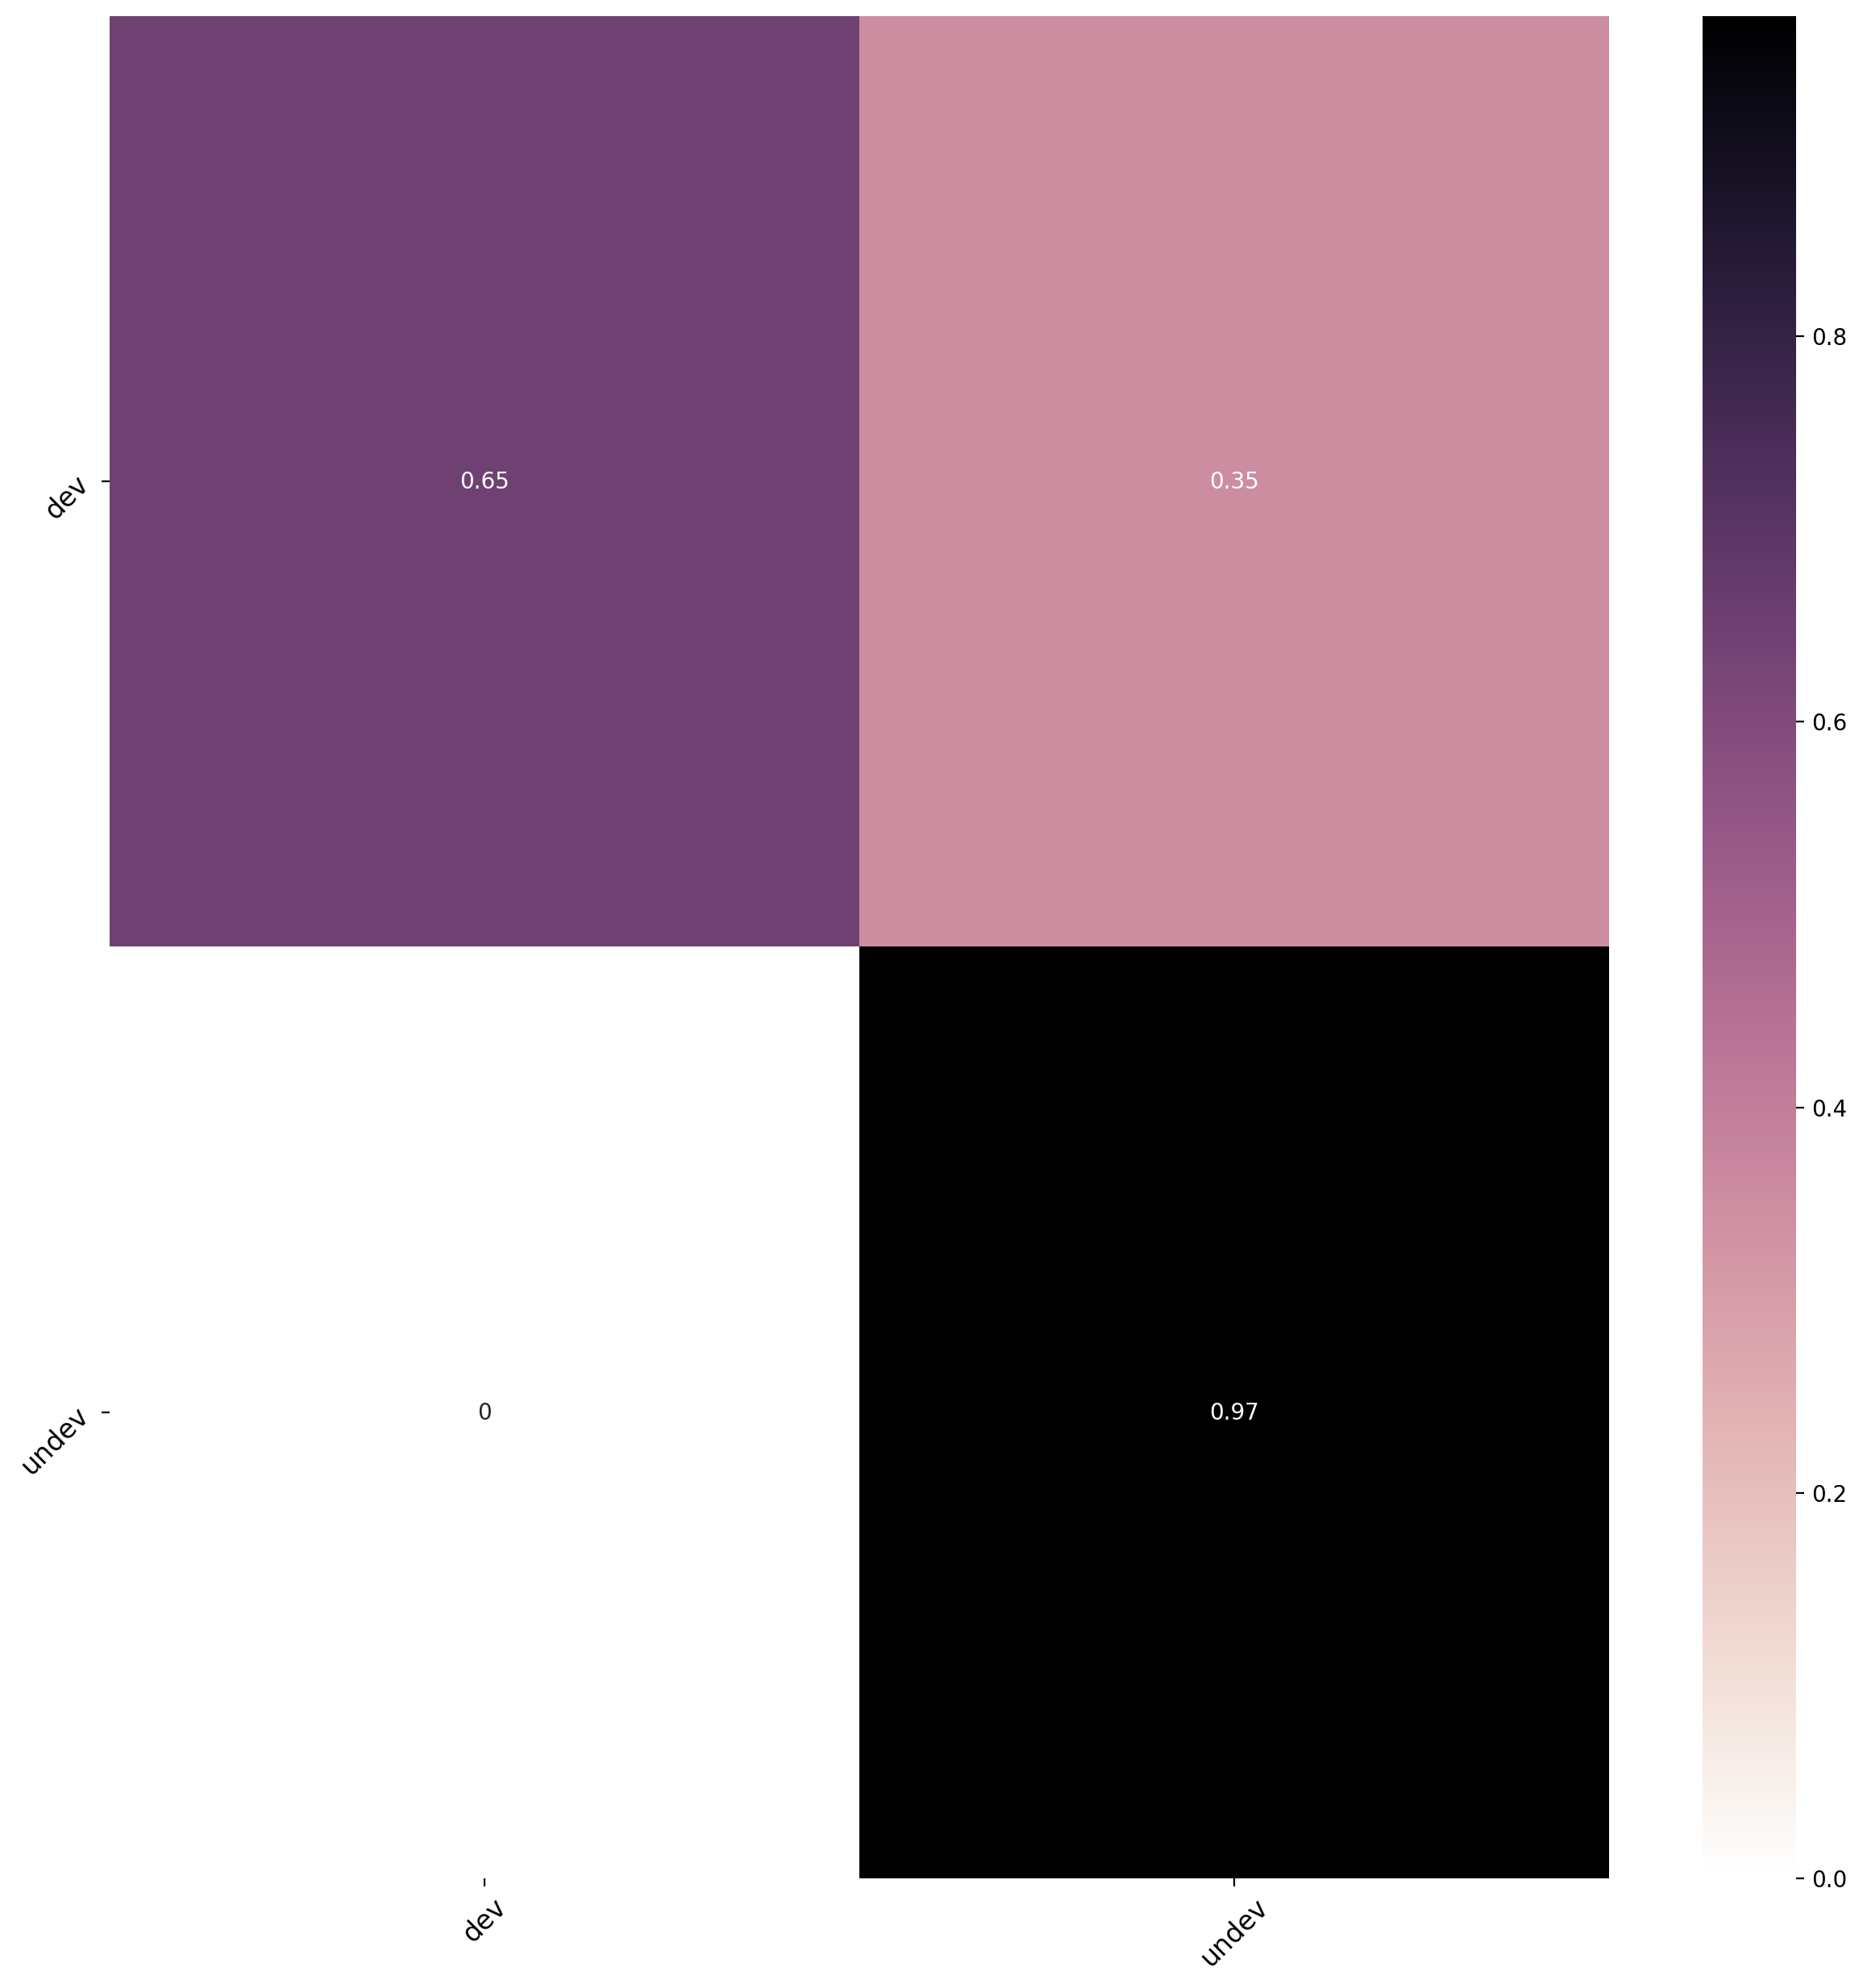

In [32]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_full_sample_2class_mv2_model2_cm_val.png", width=500, height=500)


### 3-class ('marsh', 'developed', 'other')

#### Script 1. tamucc_imrecog_part2a.py

Implements a custom deep neural network for classification on the data subset

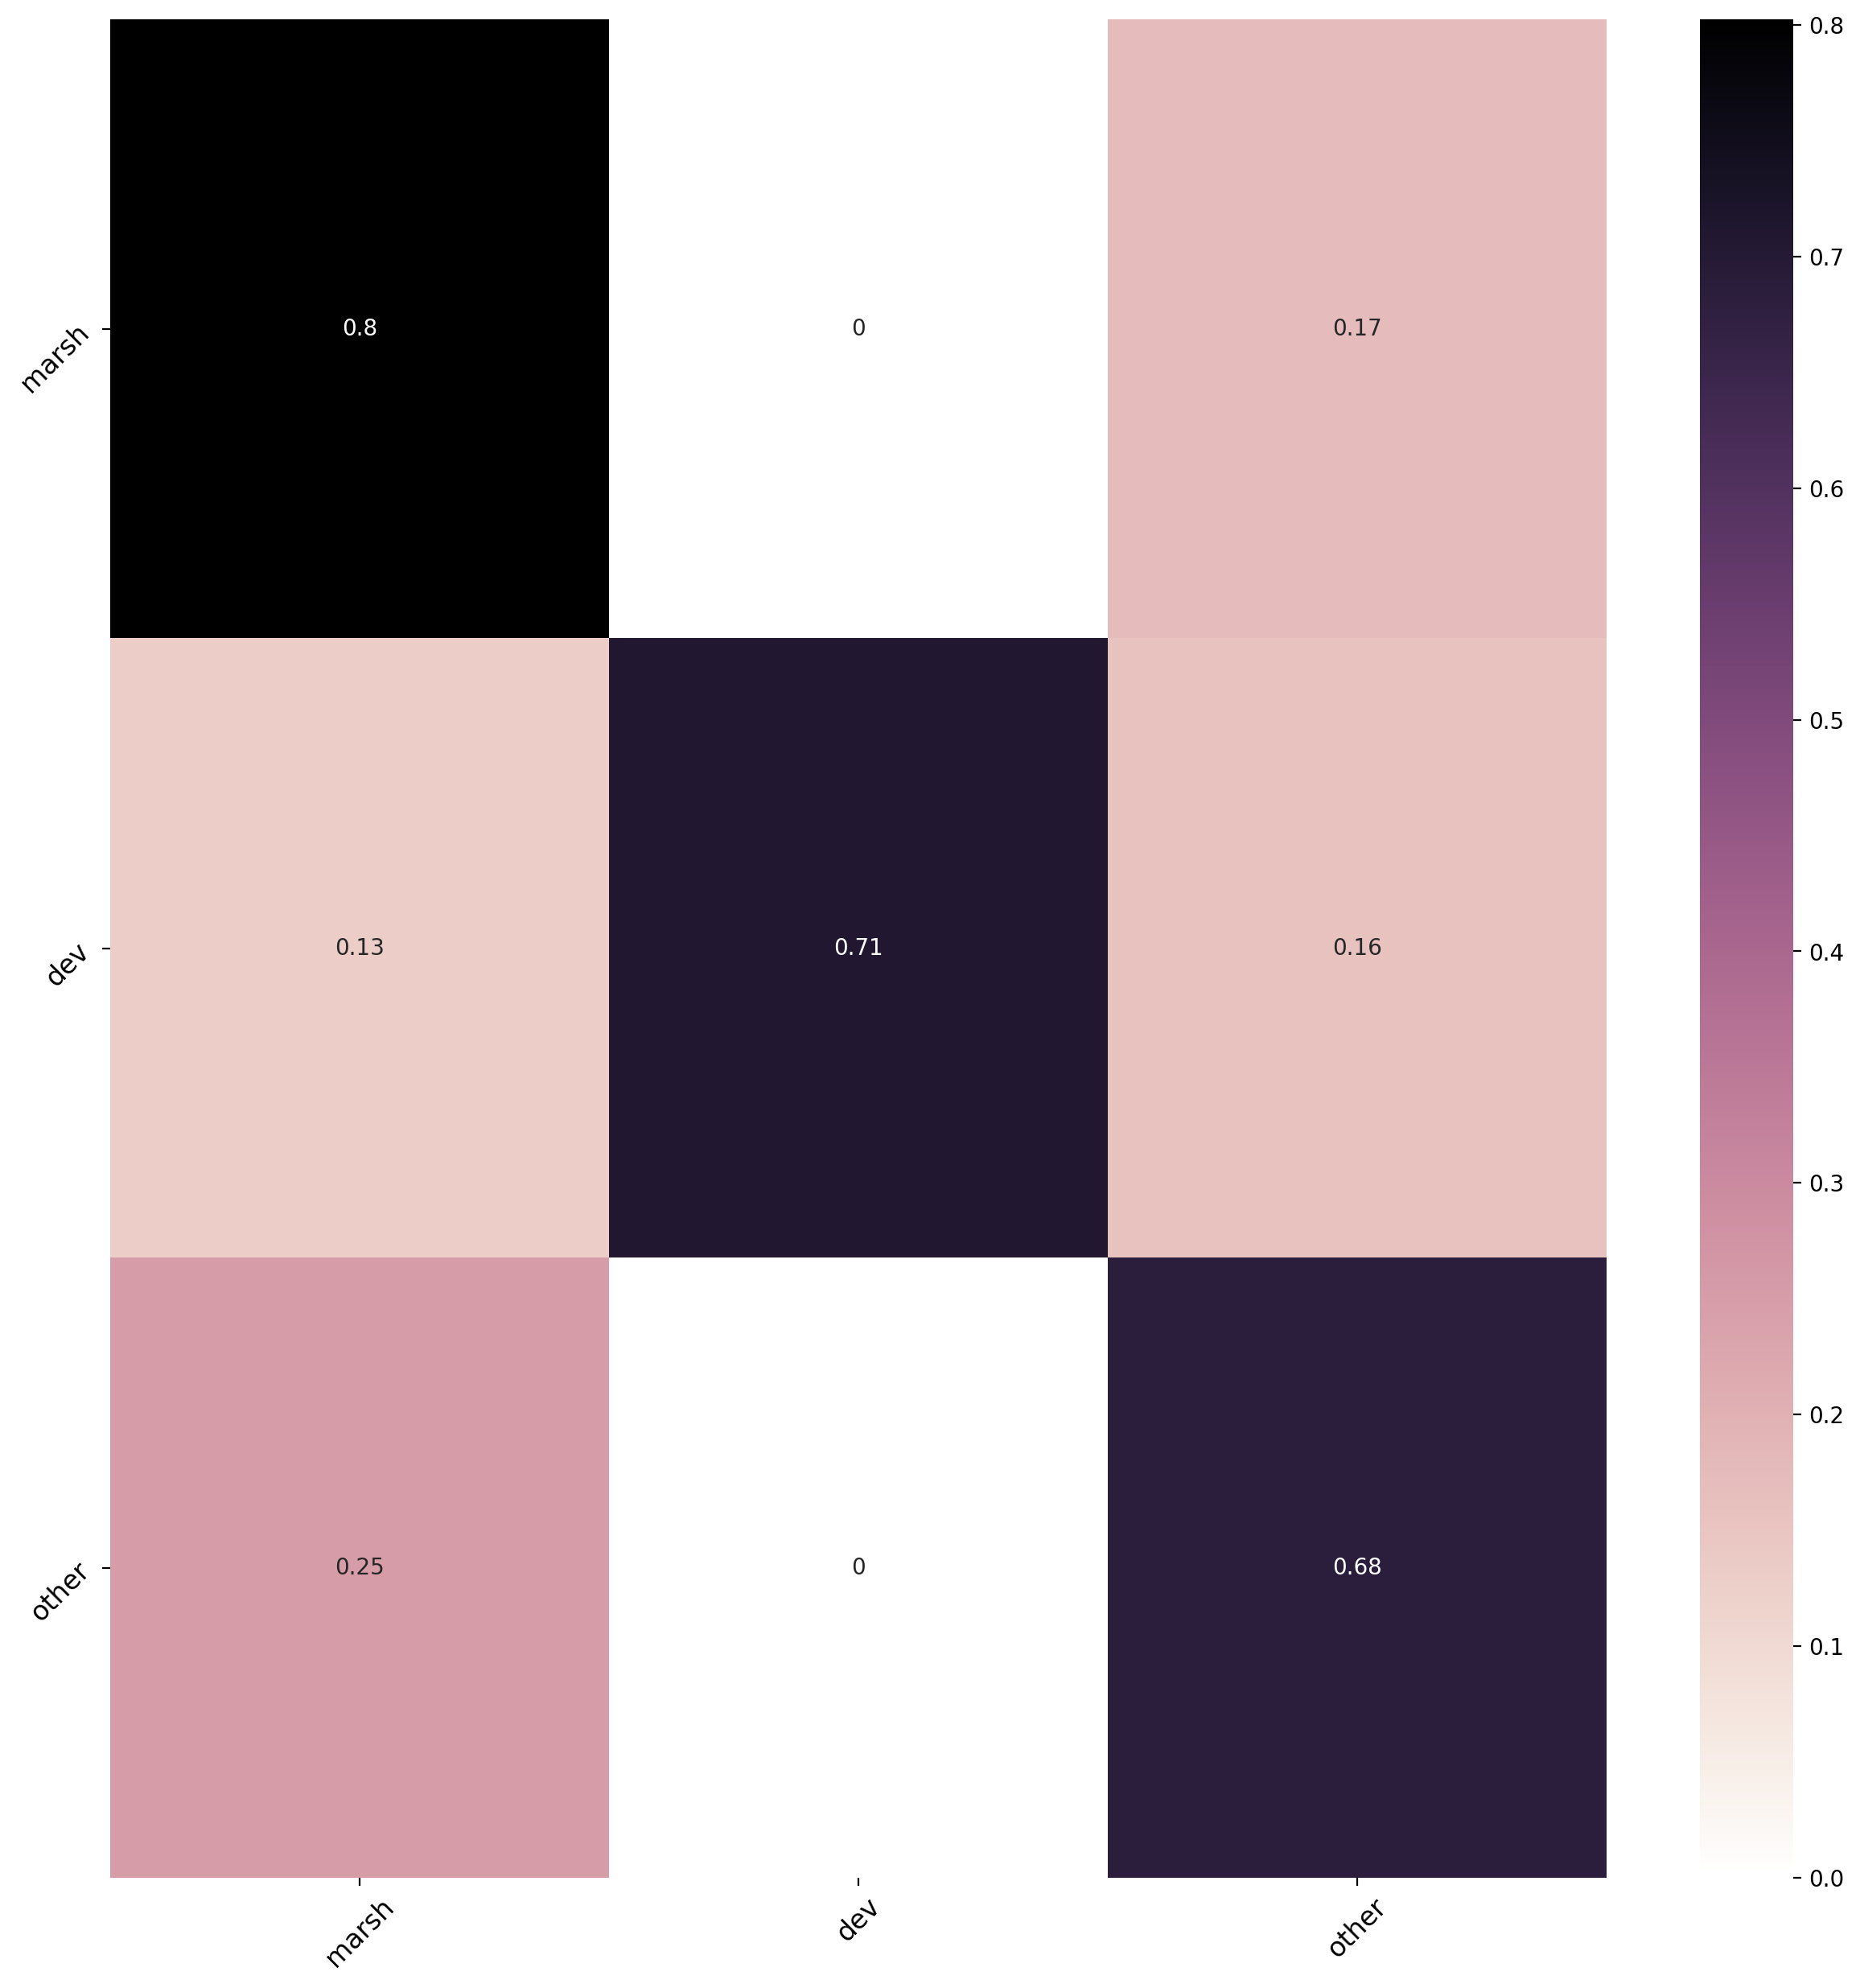

In [33]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_3class_custom_model_cm_val.png", width=500, height=500)

#### Script 2. tamucc_imrecog_part2b.py

Implements a model based on mobilenetV2, trained using weights learned from another dataset (specifically, "imagenet") - this is called transfer learning

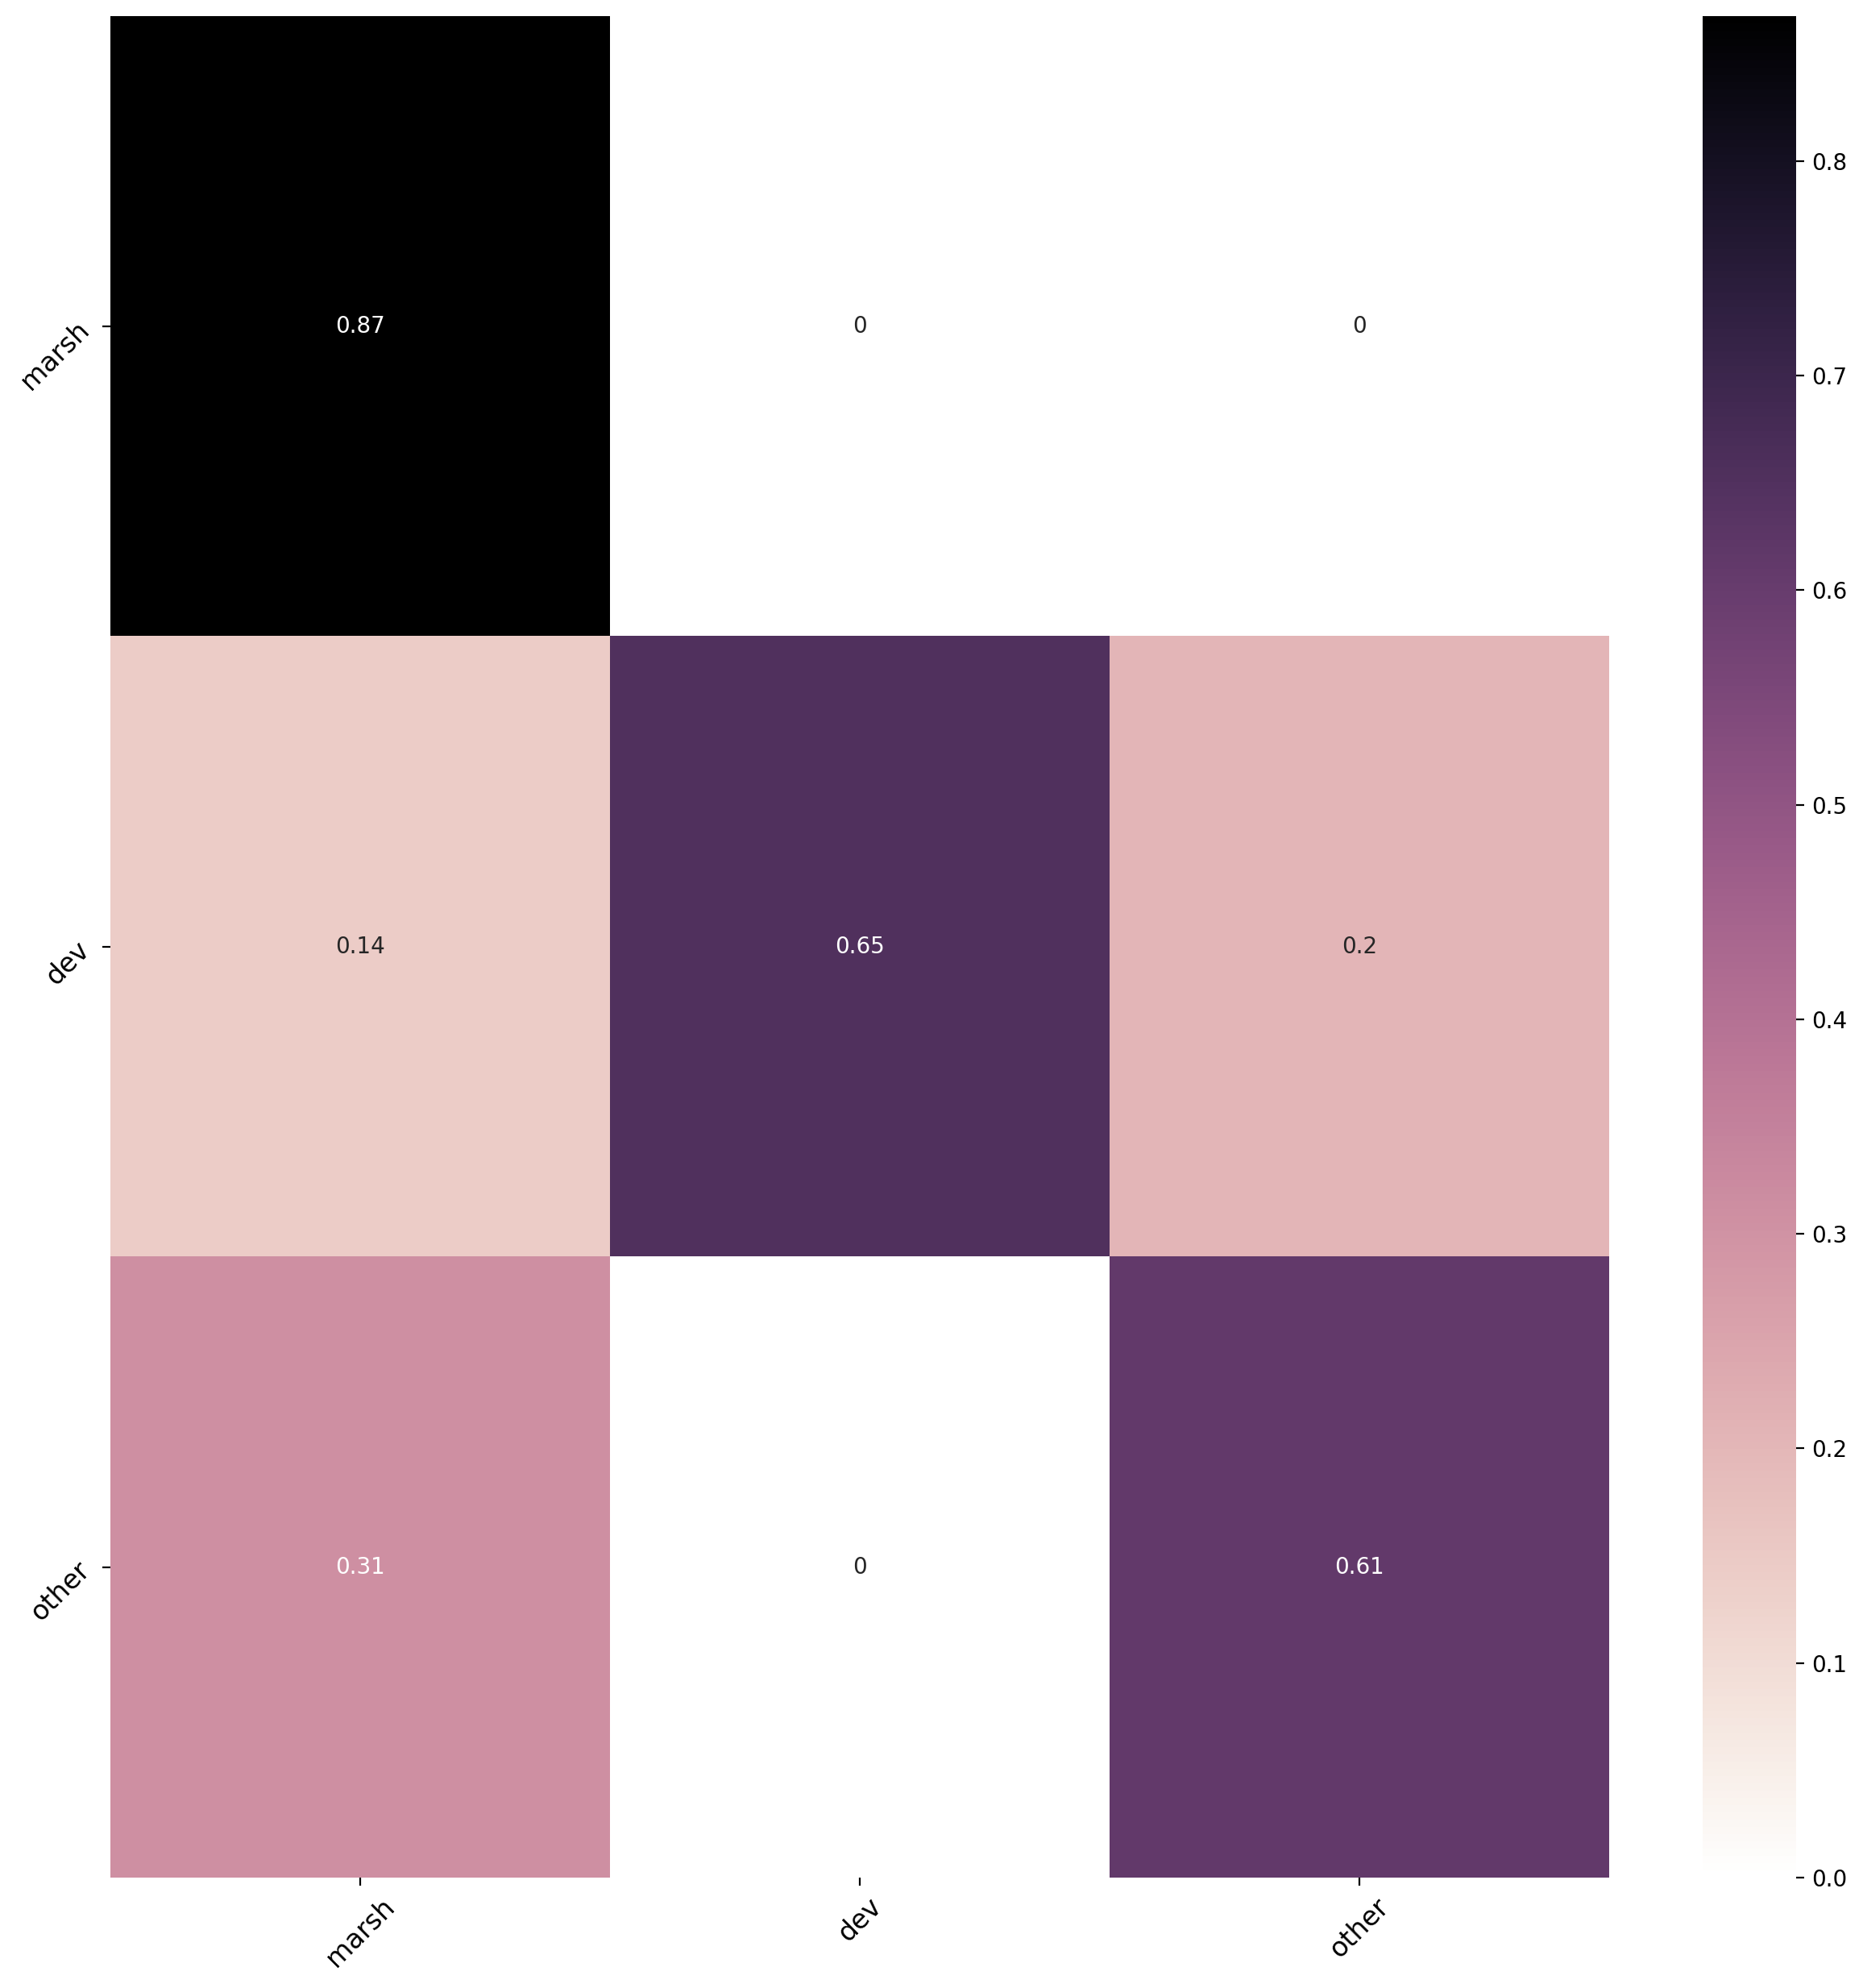

In [34]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_3class_mv2_model2_cm_val.png", width=500, height=500)

#### Script 2. tamucc_imrecog_part2c.py

Takes the model trained in `tamucc_imrecog_part2b.py`, and fine-tunes it. This means the lower layers are frozen, and the upper layers are tuned with a smaller learning rate. This is an optimization procedure

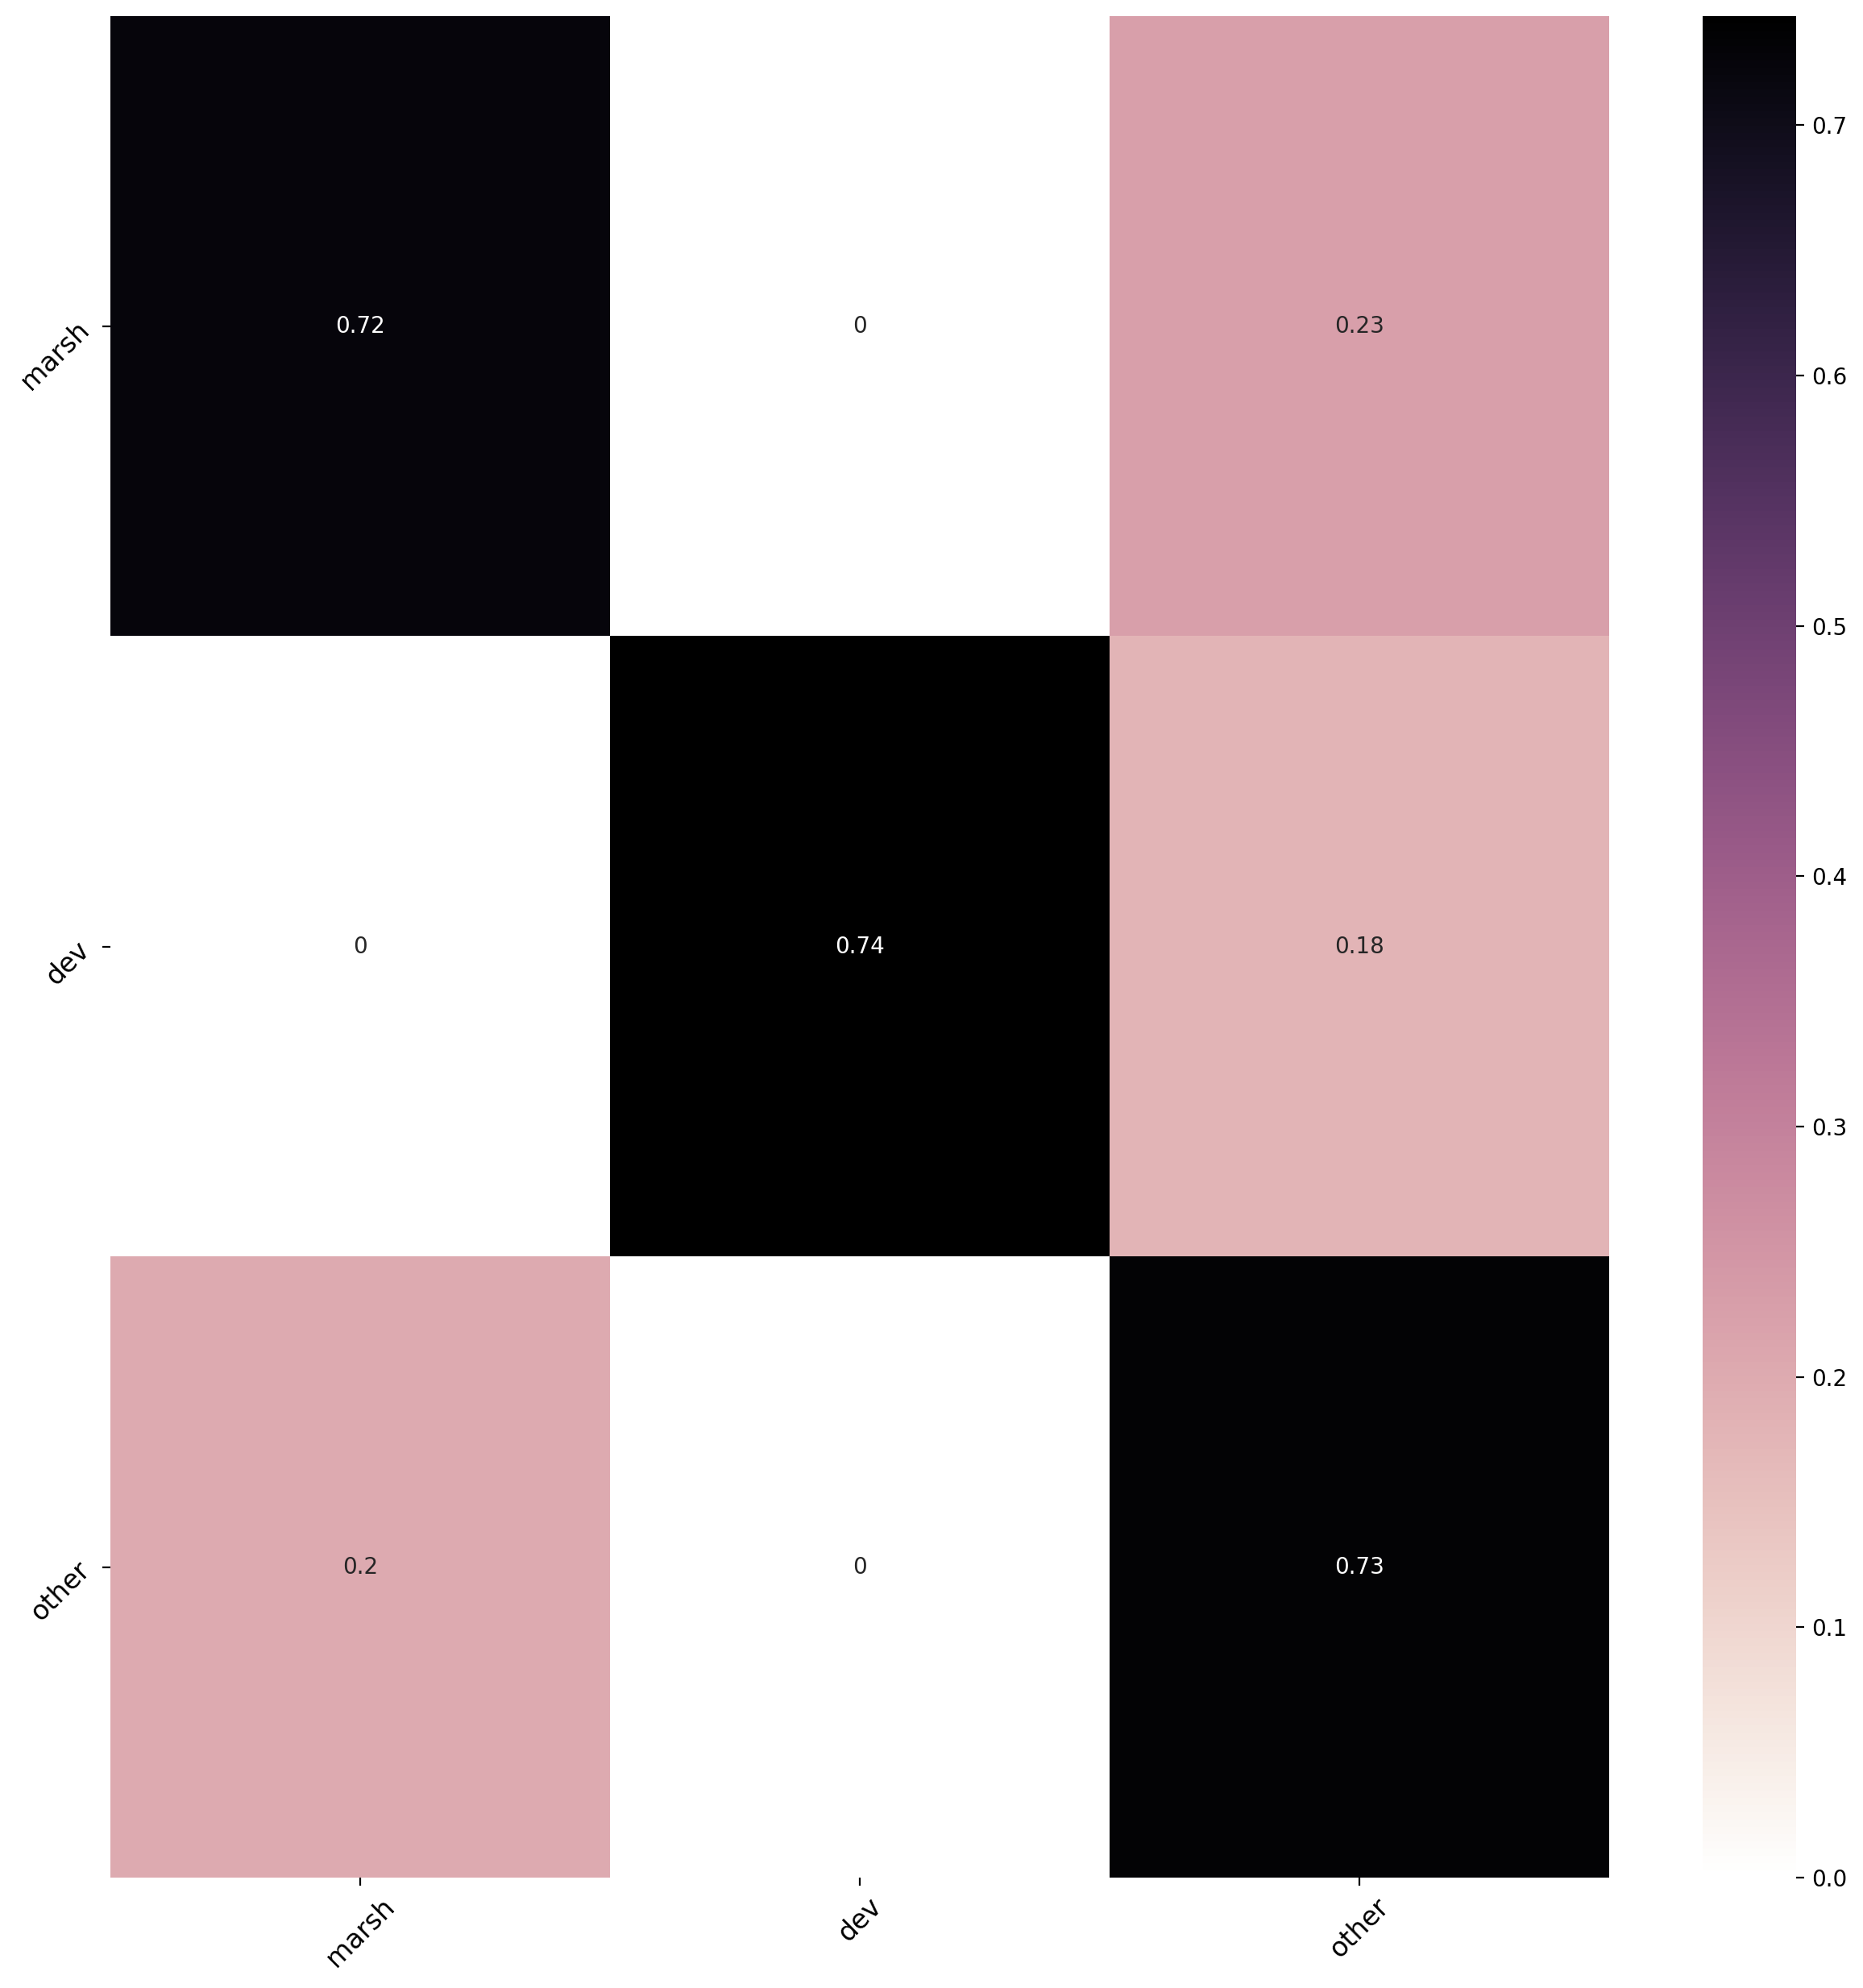

In [35]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_3class_mv2_model3_cm_val.png", width=500, height=500)


### 4-class ('sand beaches', 'gravel beaches', 'marshes', and 'manmade')

#### Script 1. tamucc_imrecog_part3a.py

Implements a model based on mobilenetV2, trained using weights learned from another dataset (specifically, "imagenet") - this is called transfer learning

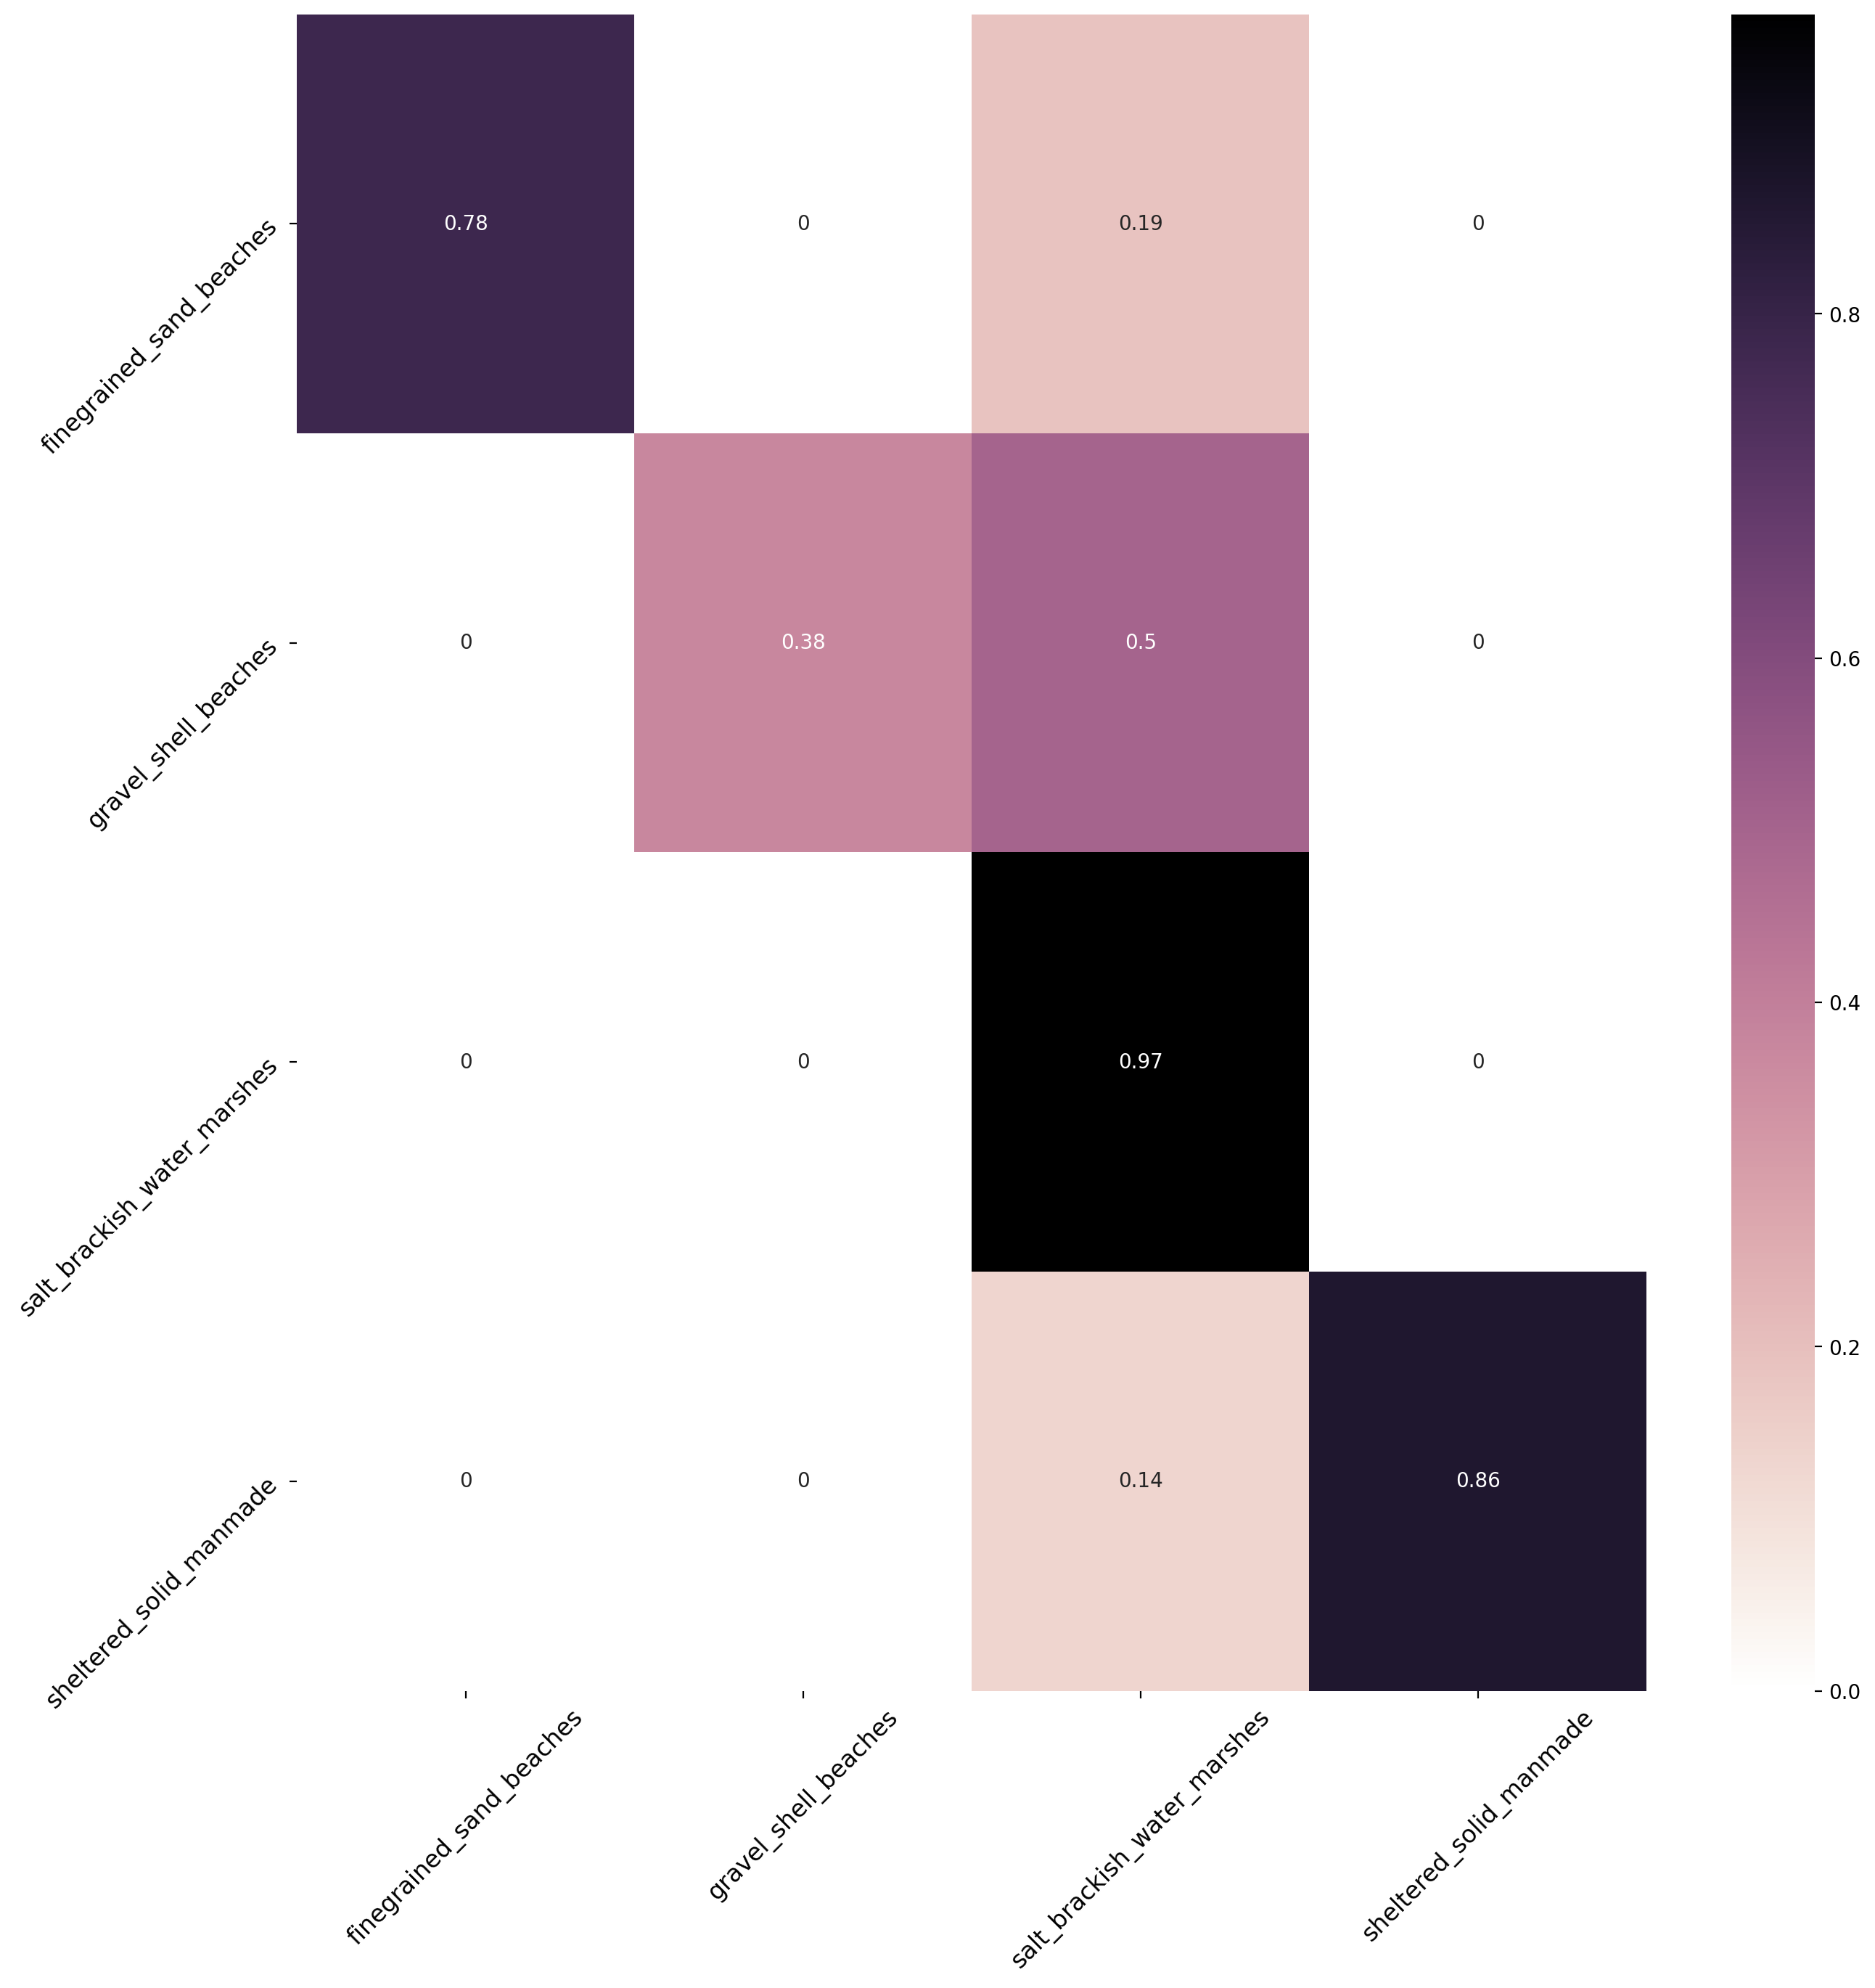

In [36]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_4class_mv2_model1_cm_val.png", width=500, height=500)

#### Script 2. tamucc_imrecog_part3b.py

Same model as above, this time trained using class weights (a measure of the relative proportion of each class in the dataset)

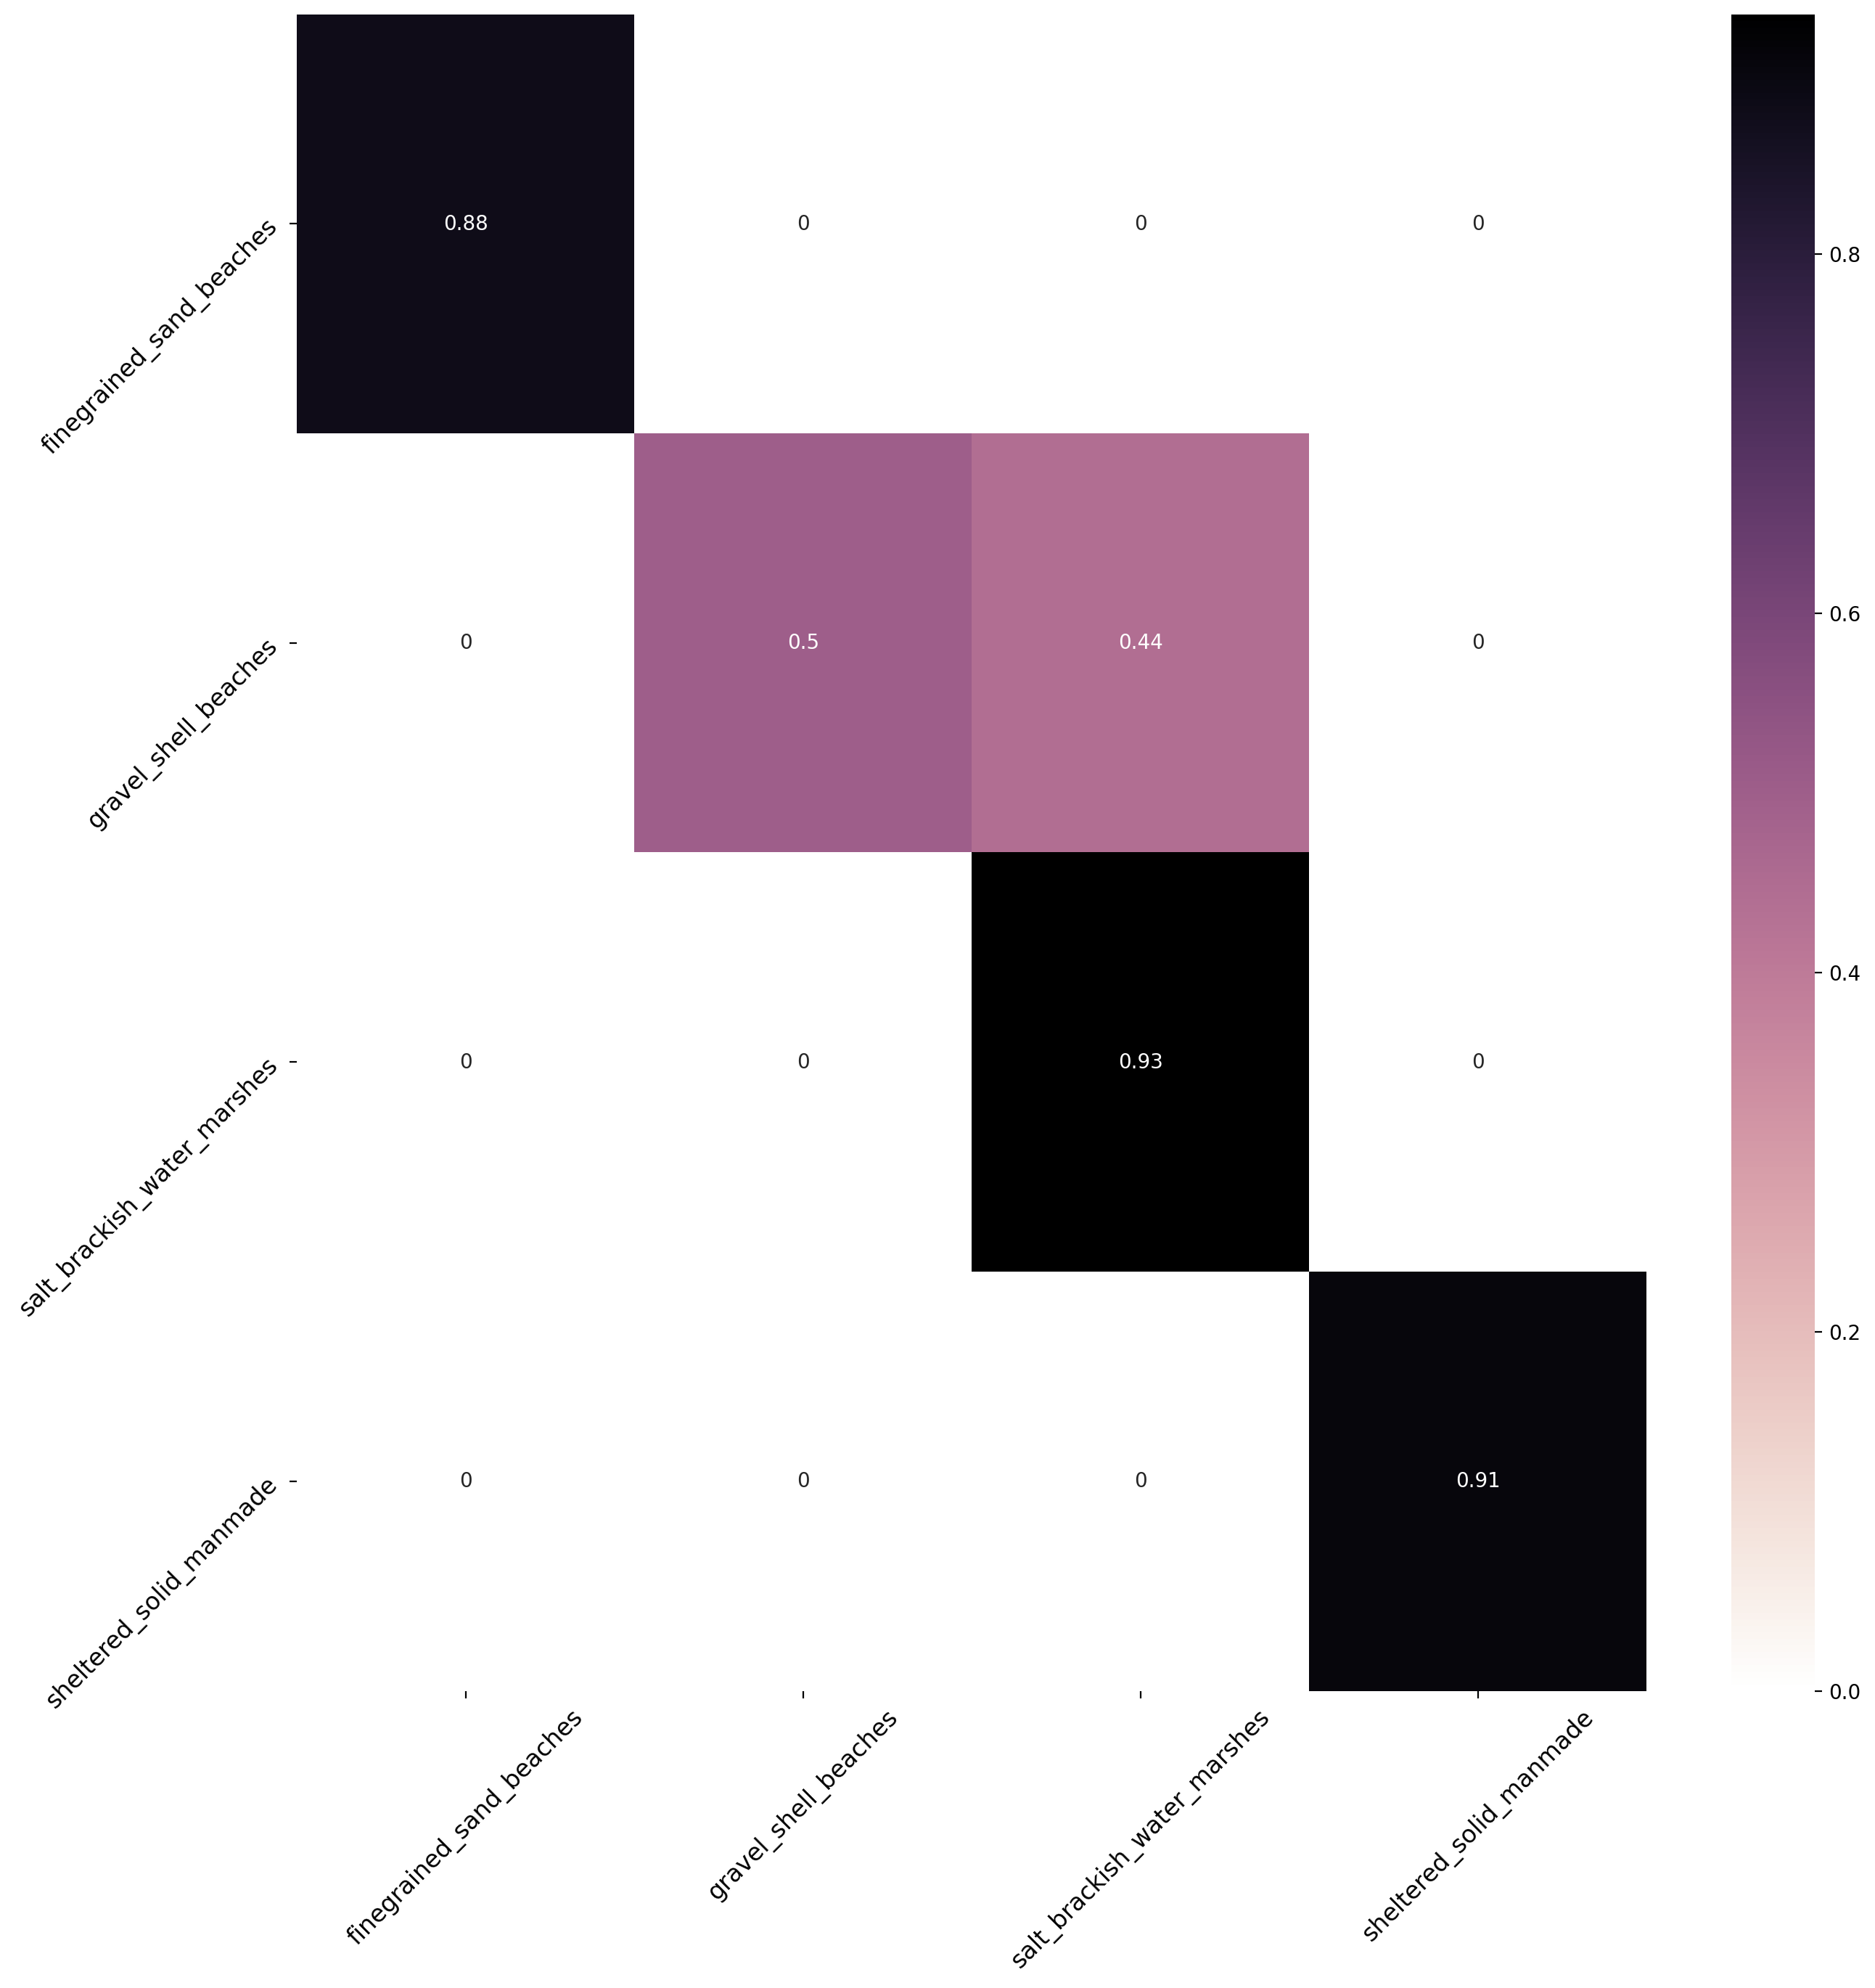

In [37]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_sample_4class_mv2_model2_cm_val.png", width=500, height=500)

#### Script 3. tamucc_imrecog_part3c.py

This is a reproduction of the workflow presented here earlier on

Implements a model based on mobilenetV2, trained using weights learned from another dataset (specifically, "imagenet"), on the full dataset

3 out of 4 classes are accurate (>90%) but the model gets confused between gravel/shell beaches and marshes about a third of the time. Examination of this imagery reveals why; often the coarse beaches front marshes, and both are visible in the scene. Greater specificity in class creation is likely required

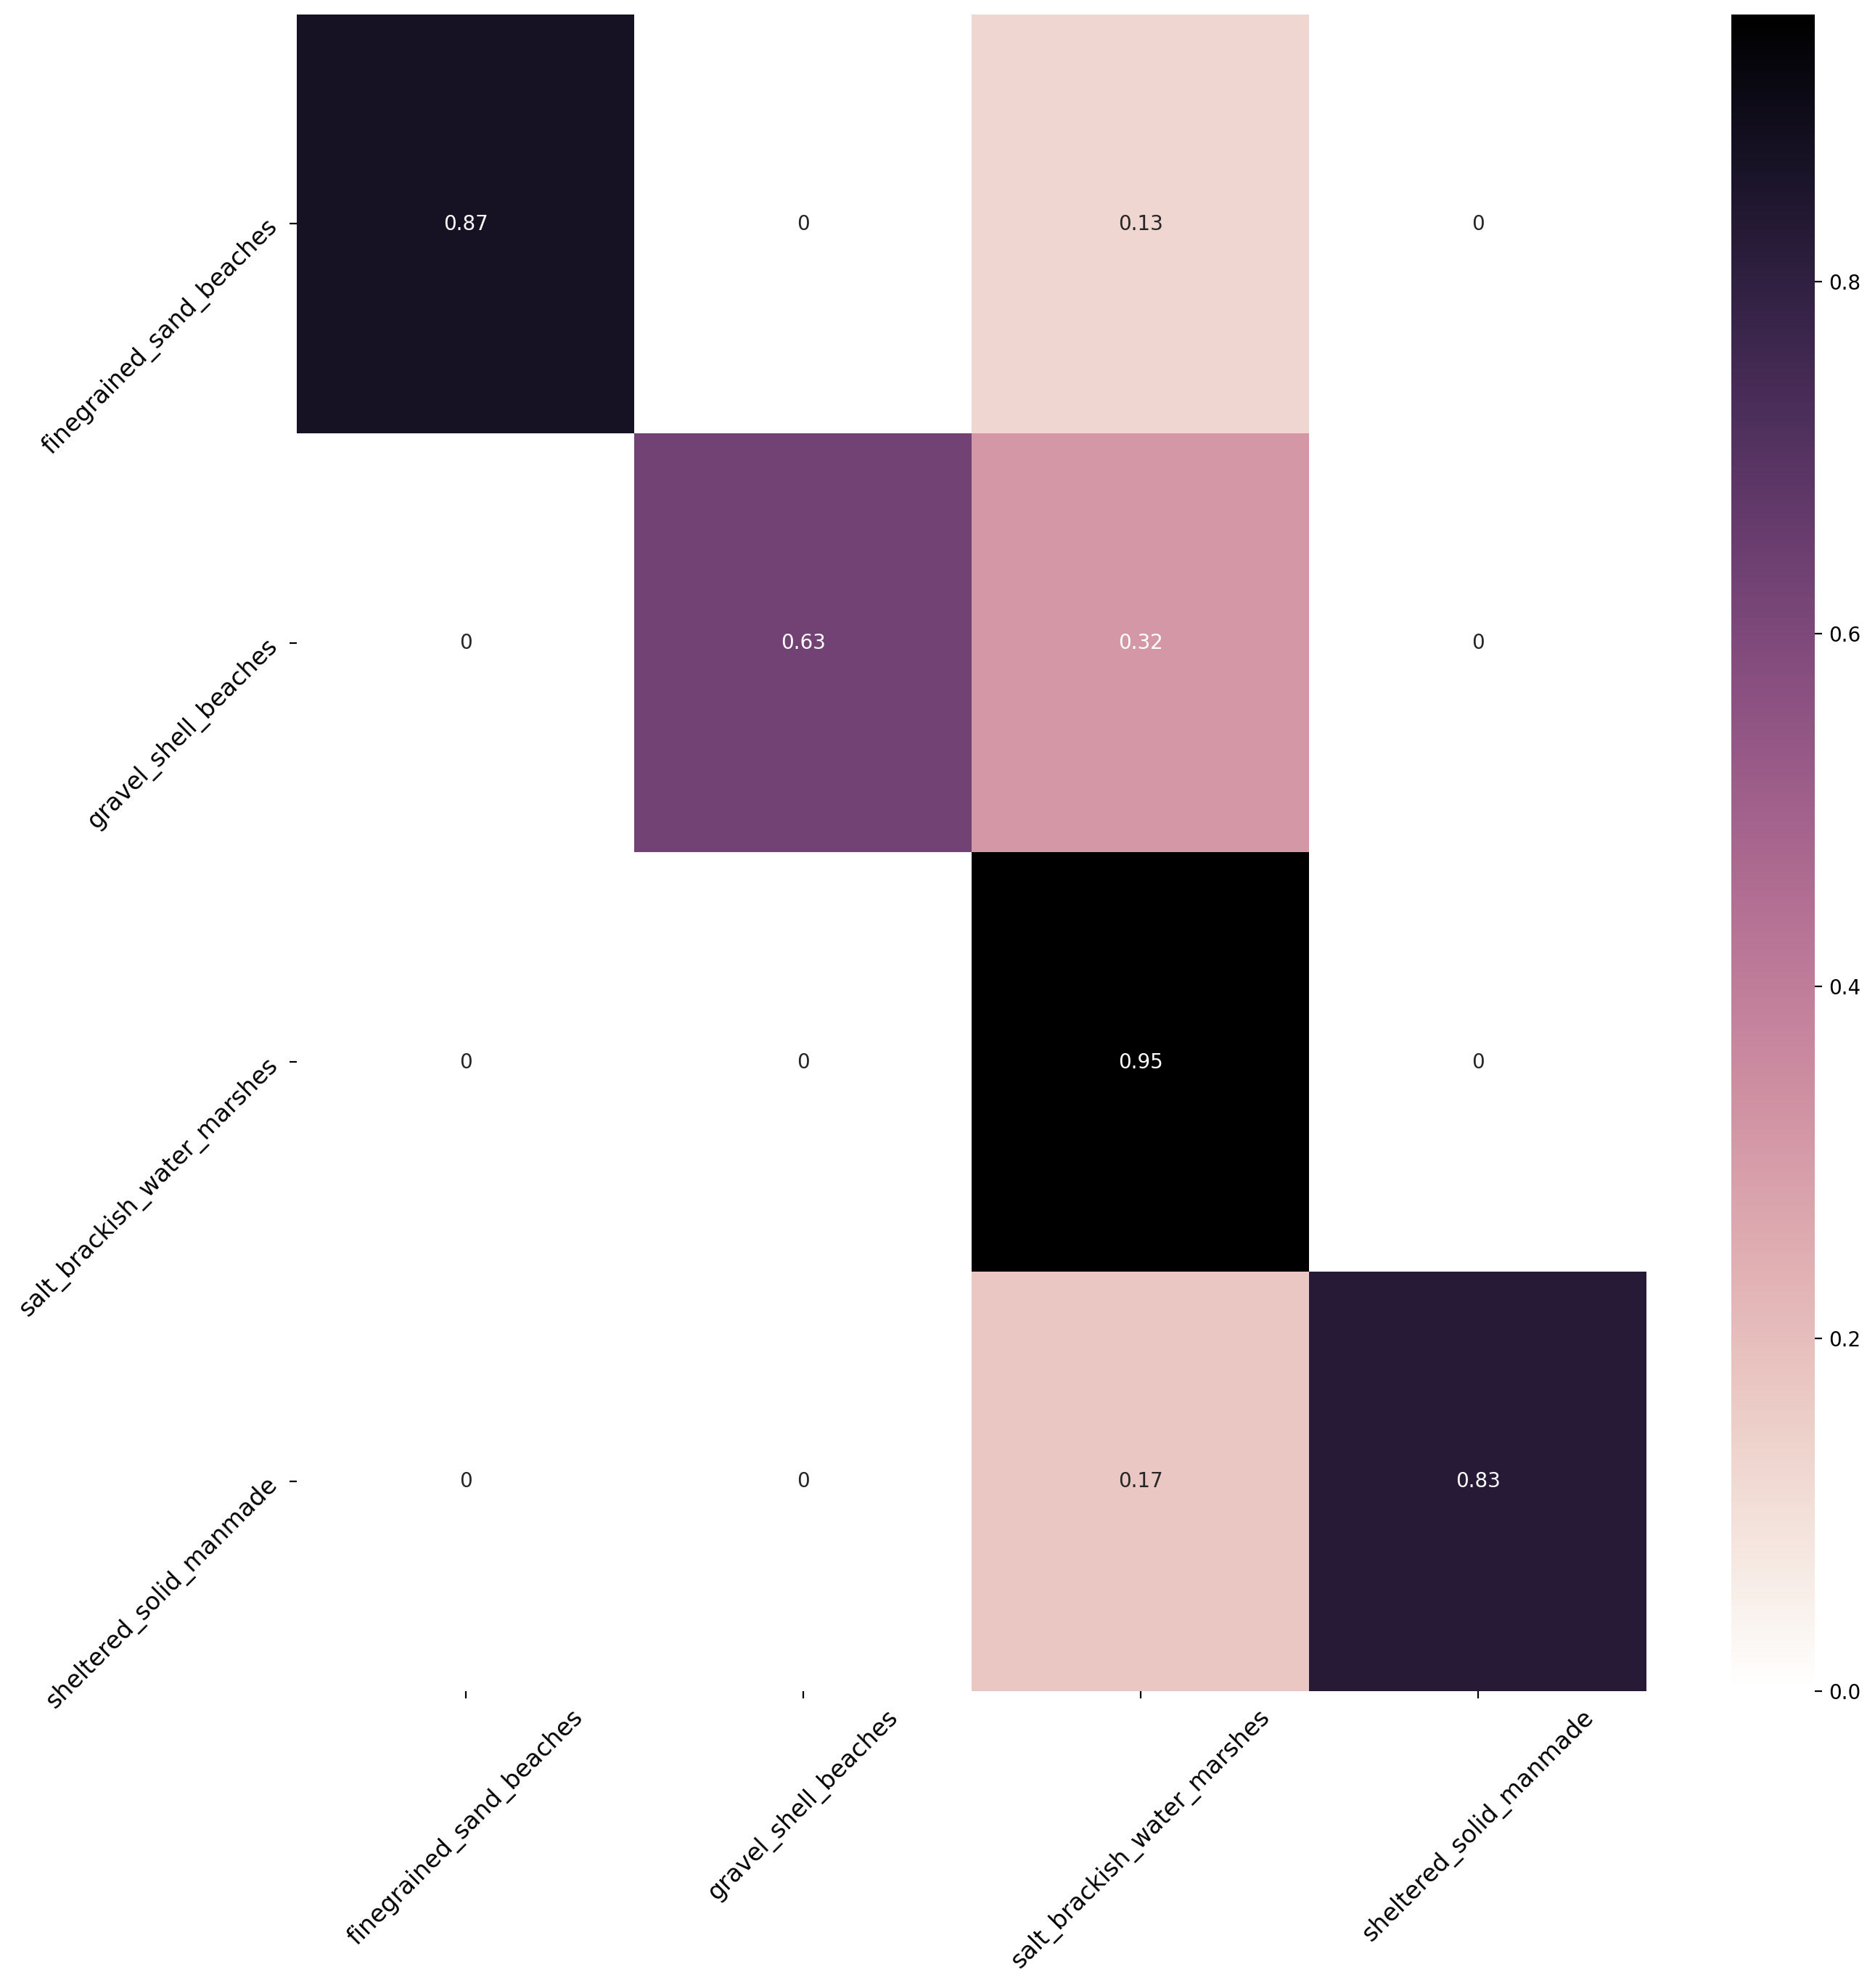

In [38]:
Image(filename = os.getcwd()+os.sep + "results/tamucc_full_4class_mv2_model3_cm_val.png", width=500, height=500)

### Data generation workflows

The three functions below are included to demonstrate how the datasets were constructed from folders of images

> tamucc_make_tfrecords_sample_2class.py

> tamucc_make_tfrecords_sample_3class.py

> tamucc_make_tfrecords_sample_4class.py

The NWPU dataset was generated using

> nwpu_make_tfrecords.py

I also wrote a [blog post](https://dbuscombe-usgs.github.io/MLMONDAYS/blog/2020/09/01/blog-post) about how to do this. Between these examples, you should be able to adapt this similar workflow for your own data


## NWPU Case study

There is only one version of the data; 224 pixel imagery and 11 classes. However, you can apply what you have learned in this lesson 

#### Script: nwpu_imrecog_part1.py

Implements a custom deep neural network for classification, just as in this lesson, based on a mobilenet V2 feature extractor and a further set of layers for feature distillation and classification

This workflow results in a confusion matrix like this, showing high accuracy of prediction for all classes - a good result!

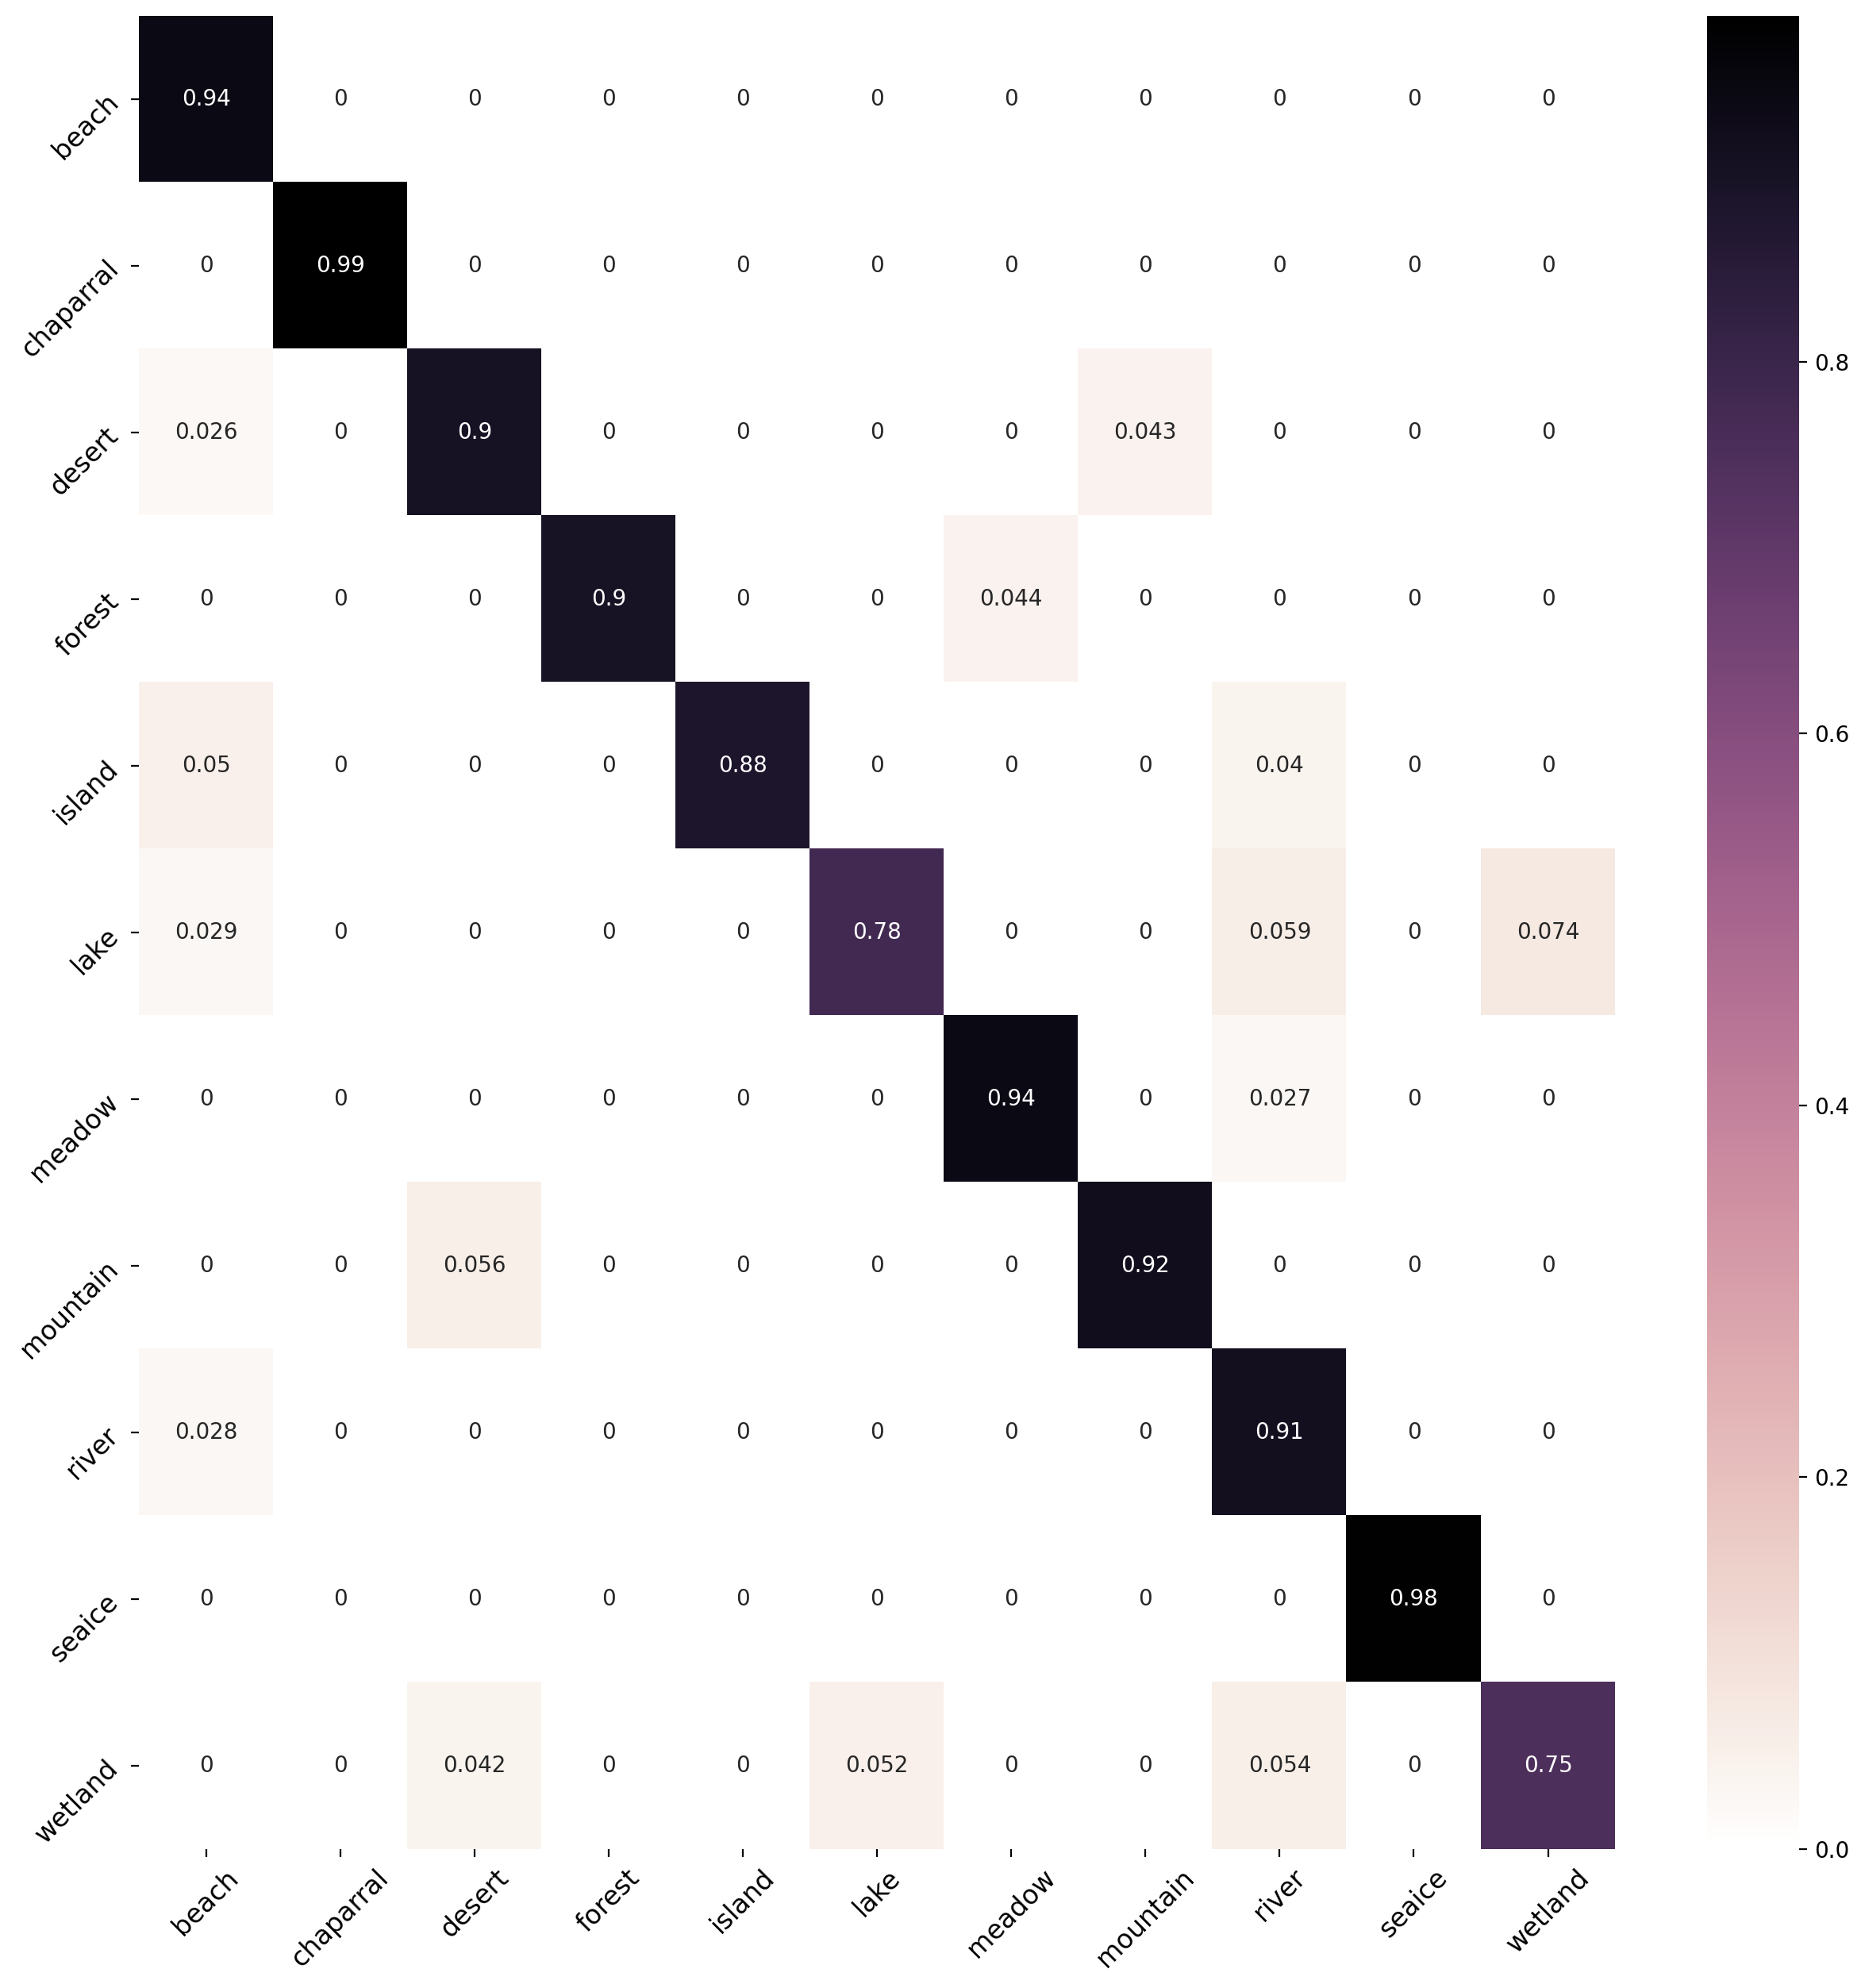

In [39]:
Image(filename = os.getcwd()+os.sep + "results/nwpu_sample_11class_mv2_model1_cm_val.png", width=500, height=500)